In [2]:
import os
import json
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import sys
import os
import pickle
import argparse
import importlib
import torch
import numpy as np
from torch.utils.data import DataLoader


# --------------------------------------------------------------------------- #
# 1.1  กำหนด Paths
# --------------------------------------------------------------------------- #
BASE_DIR   = r"z:\AST-With-TB-Classify"
DATA_DIR   = os.path.join(BASE_DIR, "Data")
PTB_DIR    = os.path.join(DATA_DIR, "Cough_PTB")
NONPTB_DIR = os.path.join(DATA_DIR, "Cough_Non-PTB")
FOLD_ROOT  = os.path.join(BASE_DIR, "json_folds_3runs")
N_RUNS            = 3
HOLDOUT_TEST_SIZE = 0.20
RUN_VAL_SIZE      = 0.15
RANDOM_STATE      = 42

SRC_DIR = os.path.join(BASE_DIR, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import dataloader as ast_dataloader
import models
import traintest as _traintest_module

importlib.reload(_traintest_module)
importlib.reload(ast_dataloader)
importlib.reload(models)

from traintest import train
# --------------------------------------------------------------------------- #
# 1.2  รวบรวม Patient ID และไฟล์เสียง
# --------------------------------------------------------------------------- #
def collect_patients(directory, label_str):
    patients = defaultdict(list)
    for wav_path in sorted(glob.glob(os.path.join(directory, "*.wav"))):
        filename   = os.path.basename(wav_path)
        patient_id = filename.split("_")[0]
        patients[patient_id].append({
            "wav":    wav_path.replace("\\", "/"),
            "labels": label_str
        })
    return patients

ptb_patients    = collect_patients(PTB_DIR,    label_str="1")
nonptb_patients = collect_patients(NONPTB_DIR, label_str="0")

ptb_ids    = sorted(ptb_patients.keys())
nonptb_ids = sorted(nonptb_patients.keys())

print(f"PTB     patients ({len(ptb_ids):2d}): {ptb_ids}")
print(f"Non-PTB patients ({len(nonptb_ids):2d}): {nonptb_ids}")
print(f"Total patients  : {len(ptb_ids) + len(nonptb_ids)}\n")

# --------------------------------------------------------------------------- #
# 1.3  สร้าง Subject-level DataFrame
#       ★ เหมือน build_subject_table_from_df() ใน 2DCNN:
#          groupby subject_id → sort_values("subject_id") → reset_index(drop=True)
# --------------------------------------------------------------------------- #
subject_records = []
for pid in sorted(set(list(ptb_patients.keys()) + list(nonptb_patients.keys()))):
    label = 1 if pid in ptb_patients else 0
    subject_records.append({"subject_id": pid, "subject_label": label})

st = (pd.DataFrame(subject_records)
        .sort_values("subject_id")
        .reset_index(drop=True))

y = st["subject_label"].values
print(f"Subject table (st) shape: {st.shape}")
print(st.to_string())

# --------------------------------------------------------------------------- #
# 1.4  Holdout Split 20%
#       ★ เหมือน 2DCNN: ส่ง DataFrame st เข้า train_test_split โดยตรง
#         จากนั้น reset_index(drop=True) ทั้ง train_subj และ test_subj
# --------------------------------------------------------------------------- #
train_subj, test_subj = train_test_split(
    st,
    test_size    = HOLDOUT_TEST_SIZE,
    stratify     = y,
    random_state = RANDOM_STATE
)
train_subj = train_subj.reset_index(drop=True)   # ★ reset index เหมือน 2DCNN
test_subj  = test_subj.reset_index(drop=True)

holdout_ids = sorted(test_subj["subject_id"].tolist())
pool_ids    = sorted(train_subj["subject_id"].tolist())

print("\n" + "=" * 65)
print("STEP 1A — Holdout Test Split (20% of all Patients)")
print("=" * 65)
print(f"  Holdout Test  : {len(test_subj)} patients "
      f"({test_subj['subject_label'].sum()} PTB + "
      f"{(test_subj['subject_label']==0).sum()} Non-PTB)")
print(f"  Pool (80%)    : {len(train_subj)} patients "
      f"({train_subj['subject_label'].sum()} PTB + "
      f"{(train_subj['subject_label']==0).sum()} Non-PTB)")
print(f"  Holdout IDs   : {holdout_ids}")
print(f"  Pool IDs      : {pool_ids}")

# --------------------------------------------------------------------------- #
# 1.5  Per-Run Splits (3 Runs)
#       ★ เหมือน 2DCNN: ส่ง train_subj DataFrame เข้า train_test_split
#         stratify=train_subj["subject_label"].values, seed=RANDOM_STATE+run_i
#         reset_index(drop=True) ทั้ง tr_subj และ va_subj
# --------------------------------------------------------------------------- #
run_assignments = []
for run_i in range(1, N_RUNS + 1):
    tr_subj, va_subj = train_test_split(
        train_subj,
        test_size    = RUN_VAL_SIZE,
        stratify     = train_subj["subject_label"].values,
        random_state = RANDOM_STATE + run_i   # 43, 44, 45 เหมือน 2DCNN
    )
    tr_subj = tr_subj.reset_index(drop=True)  # ★ reset index เหมือน 2DCNN
    va_subj = va_subj.reset_index(drop=True)

    tr_ids = sorted(tr_subj["subject_id"].tolist())
    va_ids = sorted(va_subj["subject_id"].tolist())
    te_ids = set(test_subj["subject_id"].tolist())

    # Leakage check (เหมือน 2DCNN)
    ok = (set(tr_ids).isdisjoint(set(va_ids)) and
          set(tr_ids).isdisjoint(te_ids) and
          set(va_ids).isdisjoint(te_ids))
    print(f"{'✅' if ok else '❌'} Run {run_i}: train/val/test subjects disjoint")

    run_assignments.append({
        "run":   run_i,
        "train": tr_ids,
        "val":   va_ids,
        "seed":  RANDOM_STATE + run_i,
        "tr_subj_df": tr_subj,
        "va_subj_df": va_subj,
    })

# --------------------------------------------------------------------------- #
# 1.6  Helper Functions
# --------------------------------------------------------------------------- #
def patients_to_records(patient_ids, ptb_dict, nonptb_dict):
    records = []
    for pid in patient_ids:
        if pid in ptb_dict:
            records.extend(ptb_dict[pid])
        elif pid in nonptb_dict:
            records.extend(nonptb_dict[pid])
    return records

def save_json(records, filepath):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, "w") as f:
        json.dump({"data": records}, f, indent=4)

# --------------------------------------------------------------------------- #
# 1.7  บันทึก Holdout Test JSON
# --------------------------------------------------------------------------- #
holdout_records        = patients_to_records(holdout_ids, ptb_patients, nonptb_patients)
holdout_json_path      = os.path.join(FOLD_ROOT, "holdout_test.json")
save_json(holdout_records, holdout_json_path)
n_holdout_ptb_files    = sum(1 for r in holdout_records if r["labels"] == "1")
n_holdout_nonptb_files = len(holdout_records) - n_holdout_ptb_files
print(f"\n  Holdout Test JSON → {holdout_json_path}")
print(f"  Files: {len(holdout_records)} total  [{n_holdout_ptb_files} PTB / {n_holdout_nonptb_files} Non-PTB]")

# --------------------------------------------------------------------------- #
# 1.8  บันทึก JSON ของแต่ละ Run + แสดงสรุป
# --------------------------------------------------------------------------- #
print(f"\n{'=' * 65}")
print("STEP 1B — 3 Independent Random Splits (on 80% Pool) — 2DCNN Style")
print(f"({'Val size per Run = 15% of Pool | Seeds = 43, 44, 45'})")
print(f"{'=' * 65}")

holdout_set = set(holdout_ids)
for ra in run_assignments:
    run_num = ra["run"]
    run_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")

    train_records = patients_to_records(ra["train"], ptb_patients, nonptb_patients)
    val_records   = patients_to_records(ra["val"],   ptb_patients, nonptb_patients)

    save_json(train_records, os.path.join(run_dir, "train_data.json"))
    save_json(val_records,   os.path.join(run_dir, "val_data.json"))

    n_train_ptb = sum(1 for r in train_records if r["labels"] == "1")
    n_val_ptb   = sum(1 for r in val_records   if r["labels"] == "1")
    pct_train   = len(ra["train"]) / len(pool_ids) * 100
    pct_val     = len(ra["val"])   / len(pool_ids) * 100

    print(f"\n  --- RUN {run_num} (seed={ra['seed']}) ---")
    print(f"  TRAIN : {len(ra['train']):2d} patients ({pct_train:.1f}%) "
          f"[{sum(1 for p in ra['train'] if p in ptb_patients)} PTB + "
          f"{sum(1 for p in ra['train'] if p in nonptb_patients)} Non-PTB] "
          f"→ {len(train_records):3d} files  [{n_train_ptb} PTB / {len(train_records)-n_train_ptb} Non-PTB]")
    print(f"  VAL   : {len(ra['val']):2d} patients ({pct_val:.1f}%)  "
          f"[{sum(1 for p in ra['val'] if p in ptb_patients)} PTB + "
          f"{sum(1 for p in ra['val'] if p in nonptb_patients)} Non-PTB] "
          f"→ {len(val_records):3d} files  [{n_val_ptb} PTB / {len(val_records)-n_val_ptb} Non-PTB]")
    print(f"  IDs   → TRAIN: {ra['train']} | VAL: {ra['val']}")

print(f"\n  TEST  : Shared Holdout — {len(holdout_ids)} patients "
      f"→ {len(holdout_records)} files  "
      f"[{n_holdout_ptb_files} PTB / {n_holdout_nonptb_files} Non-PTB]")
print(f"\n[✓] JSON files saved to: {FOLD_ROOT}")
print("[✓] Data preparation complete (2DCNN-Style Splitting).")


z:\AST-With-TB-Classify\venvast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
z:\AST-With-TB-Classify\venvast\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


PTB     patients ( 7): ['006', '008', '009', '011', '012', '015', '016']
Non-PTB patients ( 8): ['001', '002', '003', '004', '005', '007', '013', '014']
Total patients  : 15

Subject table (st) shape: (15, 2)
   subject_id  subject_label
0         001              0
1         002              0
2         003              0
3         004              0
4         005              0
5         006              1
6         007              0
7         008              1
8         009              1
9         011              1
10        012              1
11        013              0
12        014              0
13        015              1
14        016              1

STEP 1A — Holdout Test Split (20% of all Patients)
  Holdout Test  : 3 patients (1 PTB + 2 Non-PTB)
  Pool (80%)    : 12 patients (6 PTB + 6 Non-PTB)
  Holdout IDs   : ['004', '013', '016']
  Pool IDs      : ['001', '002', '003', '005', '006', '007', '008', '009', '011', '012', '014', '015']
✅ Run 1: train/val/test subjects 

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [3]:
# =============================================================================
# STEP 2: MODEL CONFIGURATION & 3-RUN TRAINING LOOP
# =============================================================================
# แต่ละ Run จะใช้ run_X/train_data.json และ run_X/val_data.json
# (จาก STEP 1)  ไม่มี per-run test — ทุก Run ทดสอบบน Holdout Test เดียวกัน
#
# ★ Output: exp/kfold_3runs_2dcnn/run_X/  (ไม่ทับ exp/kfold/fold_X/ เดิม)
# =============================================================================

import sys
import os
import pickle
import argparse
import importlib
import torch
import numpy as np
from torch.utils.data import DataLoader

# --------------------------------------------------------------------------- #
# 2.1  เพิ่ม src/ directory เข้า sys.path
# --------------------------------------------------------------------------- #
SRC_DIR = os.path.join(BASE_DIR, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import dataloader as ast_dataloader
import models
import traintest as _traintest_module

importlib.reload(_traintest_module)
importlib.reload(ast_dataloader)
importlib.reload(models)

from traintest import train

# --------------------------------------------------------------------------- #
# 2.2  Paths
# --------------------------------------------------------------------------- #
LABEL_CSV = os.path.join(BASE_DIR, "class_labels_indices.csv")
EXP_ROOT  = os.path.join(BASE_DIR, "exp", "kfold_3runs_2dcnn")  # ★ ต่างชื่อจากเดิม
NORM_MEAN = -4.527155
NORM_STD  =  5.118366

# --------------------------------------------------------------------------- #
# 2.3  Audio Configurations
# --------------------------------------------------------------------------- #
TRAIN_AUDIO_CONF = {
    "num_mel_bins": 128,
    "target_length": 100,
    "freqm":        48,
    "timem":        20,
    "mixup":        0.5,
    "dataset":      "audioset",
    "mode":         "train",
    "mean":        NORM_MEAN,
    "std":          NORM_STD,
    "noise":        False,
    'skip_norm': False
}

EVAL_AUDIO_CONF = {
    "num_mel_bins": 128,
    "target_length": 100,
    "freqm":        0,
    "timem":        0,
    "mixup":        0.0,
    "dataset":      "audioset",
    "mode":         "evaluation",
    "mean":        NORM_MEAN,
    "std":          NORM_STD,
    "noise":        False,
    'skip_norm': False
}

In [ ]:


# --------------------------------------------------------------------------- #
# 2.4  Training Arguments
# --------------------------------------------------------------------------- #
def make_training_args(run_exp_dir, n_epochs=20):
    return argparse.Namespace(
        exp_dir           = run_exp_dir,
        dataset           = "audioset",
        n_class           = 2,
        lr                = 1e-5,
        n_epochs          = n_epochs,
        batch_size        = 8,
        n_print_steps     = 10,
        save_model        = True,
        metrics           = "mAP",
        loss              = "CE",
        warmup            = False,
        lrscheduler_start = 5,
        lrscheduler_step  = 1,
        lrscheduler_decay = 0.85,
        wa                = True,
        wa_start          = 10,
        wa_end            = n_epochs,
    )

# --------------------------------------------------------------------------- #
# 2.5  3-RUN TRAINING LOOP
# --------------------------------------------------------------------------- #
print("=" * 65)
print("  AST-P  |  3-RUN INDEPENDENT SPLIT TRAINING (2DCNN-Style)")
print("  Strategy: Shared Holdout Test (20%) + 3 Runs on Pool (80%)")
print("  Val per Run = 15% of Pool | Seeds = 43, 44, 45")
print("=" * 65)
print(f"  Device  : {'CUDA (' + torch.cuda.get_device_name(0) + ')' if torch.cuda.is_available() else 'CPU'}")
print(f"  Epochs  : 20  |  LR: 1e-5  |  Batch: 8  |  WA: epoch 10→20")
print("=" * 65)

for ra in run_assignments:
    run_num = ra["run"]

    print(f"\n{'━'*65}")
    print(f"  ▶  RUN {run_num} / {N_RUNS}  TRAINING START  (seed={ra['seed']})")
    print(f"{'━'*65}")

    run_data_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")
    run_exp_dir  = os.path.join(EXP_ROOT,  f"run_{run_num}")
    os.makedirs(os.path.join(run_exp_dir, "models"),      exist_ok=True)
    os.makedirs(os.path.join(run_exp_dir, "predictions"), exist_ok=True)

    train_json = os.path.join(run_data_dir, "train_data.json")
    val_json   = os.path.join(run_data_dir, "val_data.json")

    train_dataset = ast_dataloader.AudiosetDataset(
        train_json, audio_conf=TRAIN_AUDIO_CONF, label_csv=LABEL_CSV)
    train_loader  = DataLoader(
        train_dataset, batch_size=8, shuffle=True,
        num_workers=0, pin_memory=torch.cuda.is_available())

    val_dataset = ast_dataloader.AudiosetDataset(
        val_json, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
    val_loader  = DataLoader(
        val_dataset, batch_size=16, shuffle=False,
        num_workers=0, pin_memory=torch.cuda.is_available())

    print(f"\n  [Data] Train: {len(train_dataset)} files | Val: {len(val_dataset)} files")

    audio_model = models.ASTModel(
        label_dim         = 2,
        fstride           = 10,
        tstride           = 10,
        input_fdim        = 128,
        input_tdim        = 100,
        imagenet_pretrain = True,
        audioset_pretrain = True,
        model_size        = "base384"
    )

    args = make_training_args(run_exp_dir, n_epochs=20)
    with open(os.path.join(run_exp_dir, "args.pkl"), "wb") as f:
        pickle.dump(args, f)

    print(f"  [Model] AST-P created → output: {run_exp_dir}")
    print(f"  [Training] Starting {args.n_epochs} epochs...\n")

    train(audio_model, train_loader, val_loader, args)

    print(f"\n  [✓] RUN {run_num} training complete.")
    print(f"      Results  → {run_exp_dir}/result.csv")
    print(f"      WA Model → {run_exp_dir}/models/audio_model_wa.pth")

print(f"\n{'═'*65}")
print("  [✓] ALL 3 RUNS TRAINING COMPLETE")
print(f"{'═'*65}")

  AST-P  |  3-RUN INDEPENDENT SPLIT TRAINING (2DCNN-Style)
  Strategy: Shared Holdout Test (20%) + 3 Runs on Pool (80%)
  Val per Run = 15% of Pool | Seeds = 43, 44, 45
  Device  : CPU
  Epochs  : 20  |  LR: 1e-5  |  Batch: 8  |  WA: epoch 10→20

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ▶  RUN 1 / 3  TRAINING START  (seed=43)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
---------------the train dataloader---------------
now using following mask: 48 freq, 20 time
now using mix-up with rate 0.500000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2

  [Data] Train: 346 files | Val: 54 files
---------------AST Model Summary---------------
ImageNet pret

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/44]	Per Sample Total Time 0.90237	Per Sample Data Time 0.00515	Per Sample DNN Time 0.89722	Train Loss 0.7831	
Epoch: [1][20/44]	Per Sample Total Time 0.89795	Per Sample Data Time 0.00550	Per Sample DNN Time 0.89245	Train Loss 0.6748	
Epoch: [1][30/44]	Per Sample Total Time 0.89882	Per Sample Data Time 0.00532	Per Sample DNN Time 0.89350	Train Loss 0.6180	
Epoch: [1][40/44]	Per Sample Total Time 0.89501	Per Sample Data Time 0.00522	Per Sample DNN Time 0.88979	Train Loss 0.5528	
start validation
mAP: 0.657220
AUC: 0.855000
Avg Precision: 0.524330
Avg Recall: 1.000000
d_prime: 1.496410
train_loss: 0.538676
valid_loss: 0.670520
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 338.003
---------------
2026-02-23 14:56:48.899199
current #epochs=2, #steps=44


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][6/44]	Per Sample Total Time 0.94000	Per Sample Data Time 0.00507	Per Sample DNN Time 0.93494	Train Loss 0.4243	
Epoch: [2][16/44]	Per Sample Total Time 0.92630	Per Sample Data Time 0.00518	Per Sample DNN Time 0.92112	Train Loss 0.4021	
Epoch: [2][26/44]	Per Sample Total Time 0.94827	Per Sample Data Time 0.00511	Per Sample DNN Time 0.94316	Train Loss 0.4184	
Epoch: [2][36/44]	Per Sample Total Time 0.94922	Per Sample Data Time 0.00515	Per Sample DNN Time 0.94407	Train Loss 0.4117	
start validation
mAP: 0.881190
AUC: 0.962500
Avg Precision: 0.644042
Avg Recall: 1.000000
d_prime: 2.517957
train_loss: 0.400643
valid_loss: 0.471341
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 350.302
---------------
2026-02-23 15:02:39.201863
current #epochs=3, #steps=88


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/44]	Per Sample Total Time 1.23484	Per Sample Data Time 0.00822	Per Sample DNN Time 1.22662	Train Loss 0.5079	
Epoch: [3][12/44]	Per Sample Total Time 1.10410	Per Sample Data Time 0.00649	Per Sample DNN Time 1.09761	Train Loss 0.2697	
Epoch: [3][22/44]	Per Sample Total Time 1.02071	Per Sample Data Time 0.00581	Per Sample DNN Time 1.01489	Train Loss 0.2921	
Epoch: [3][32/44]	Per Sample Total Time 0.99647	Per Sample Data Time 0.00575	Per Sample DNN Time 0.99072	Train Loss 0.2718	
Epoch: [3][42/44]	Per Sample Total Time 1.04785	Per Sample Data Time 0.00586	Per Sample DNN Time 1.04199	Train Loss 0.2469	
start validation
mAP: 0.879955
AUC: 0.975000
Avg Precision: 0.712418
Avg Recall: 1.000000
d_prime: 2.771808
train_loss: 0.246009
valid_loss: 0.495025
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 386.387
---------------
2026-02-23 15:09:05.587902
current #epochs=4, #steps=132


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][8/44]	Per Sample Total Time 1.31147	Per Sample Data Time 0.00766	Per Sample DNN Time 1.30382	Train Loss 0.1563	
Epoch: [4][18/44]	Per Sample Total Time 1.28246	Per Sample Data Time 0.00811	Per Sample DNN Time 1.27435	Train Loss 0.2127	
Epoch: [4][28/44]	Per Sample Total Time 1.26865	Per Sample Data Time 0.00781	Per Sample DNN Time 1.26083	Train Loss 0.1794	
Epoch: [4][38/44]	Per Sample Total Time 1.25905	Per Sample Data Time 0.00751	Per Sample DNN Time 1.25154	Train Loss 0.1831	
start validation
mAP: 0.958333
AUC: 0.995000
Avg Precision: 0.833333
Avg Recall: 1.000000
d_prime: 3.642773
train_loss: 0.196701
valid_loss: 0.409650
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 458.780
---------------
2026-02-23 15:16:44.369219
current #epochs=5, #steps=176


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/44]	Per Sample Total Time 1.18872	Per Sample Data Time 0.00687	Per Sample DNN Time 1.18185	Train Loss 0.2309	
Epoch: [5][14/44]	Per Sample Total Time 1.18227	Per Sample Data Time 0.00696	Per Sample DNN Time 1.17531	Train Loss 0.2252	
Epoch: [5][24/44]	Per Sample Total Time 1.18675	Per Sample Data Time 0.00672	Per Sample DNN Time 1.18004	Train Loss 0.1846	
Epoch: [5][34/44]	Per Sample Total Time 1.20105	Per Sample Data Time 0.00662	Per Sample DNN Time 1.19443	Train Loss 0.1591	
start validation
mAP: 0.943750
AUC: 0.995000
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.642773
train_loss: 0.157958
valid_loss: 0.402593
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 438.519
---------------
2026-02-23 15:24:02.887574
current #epochs=6, #steps=220


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][0/44]	Per Sample Total Time 1.16388	Per Sample Data Time 0.00662	Per Sample DNN Time 1.15726	Train Loss 0.0804	
Epoch: [6][10/44]	Per Sample Total Time 1.23428	Per Sample Data Time 0.00847	Per Sample DNN Time 1.22581	Train Loss 0.2355	
Epoch: [6][20/44]	Per Sample Total Time 1.23775	Per Sample Data Time 0.00785	Per Sample DNN Time 1.22990	Train Loss 0.2093	
Epoch: [6][30/44]	Per Sample Total Time 1.23925	Per Sample Data Time 0.00752	Per Sample DNN Time 1.23173	Train Loss 0.1917	
Epoch: [6][40/44]	Per Sample Total Time 1.23404	Per Sample Data Time 0.00721	Per Sample DNN Time 1.22683	Train Loss 0.1773	
start validation
mAP: 0.915179
AUC: 0.990000
Avg Precision: 0.785714
Avg Recall: 1.000000
d_prime: 3.289953
train_loss: 0.176138
valid_loss: 0.503832
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 448.912
---------------
2026-02-23 15:31:31.799260
current #epochs=7, #steps=264


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/44]	Per Sample Total Time 1.20059	Per Sample Data Time 0.00597	Per Sample DNN Time 1.19462	Train Loss 0.2818	
Epoch: [7][16/44]	Per Sample Total Time 1.19306	Per Sample Data Time 0.00600	Per Sample DNN Time 1.18706	Train Loss 0.2151	
Epoch: [7][26/44]	Per Sample Total Time 1.18856	Per Sample Data Time 0.00597	Per Sample DNN Time 1.18259	Train Loss 0.1808	
Epoch: [7][36/44]	Per Sample Total Time 1.18174	Per Sample Data Time 0.00612	Per Sample DNN Time 1.17562	Train Loss 0.1995	
start validation
mAP: 0.927083
AUC: 0.992500
Avg Precision: 0.833333
Avg Recall: 1.000000
d_prime: 3.439903
train_loss: 0.187239
valid_loss: 0.416075
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 428.845
---------------
2026-02-23 15:38:40.644601
current #epochs=8, #steps=308


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][2/44]	Per Sample Total Time 1.17504	Per Sample Data Time 0.00586	Per Sample DNN Time 1.16918	Train Loss 0.1334	
Epoch: [8][12/44]	Per Sample Total Time 1.17524	Per Sample Data Time 0.00571	Per Sample DNN Time 1.16953	Train Loss 0.1696	
Epoch: [8][22/44]	Per Sample Total Time 1.17204	Per Sample Data Time 0.00563	Per Sample DNN Time 1.16641	Train Loss 0.1479	
Epoch: [8][32/44]	Per Sample Total Time 1.16936	Per Sample Data Time 0.00559	Per Sample DNN Time 1.16377	Train Loss 0.1740	
Epoch: [8][42/44]	Per Sample Total Time 1.16835	Per Sample Data Time 0.00558	Per Sample DNN Time 1.16277	Train Loss 0.1754	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.176690
valid_loss: 0.383252
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 427.602
---------------
2026-02-23 15:45:48.246645
current #epochs=9, #steps=352


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/44]	Per Sample Total Time 1.17385	Per Sample Data Time 0.00616	Per Sample DNN Time 1.16769	Train Loss 0.1632	
Epoch: [9][18/44]	Per Sample Total Time 1.16789	Per Sample Data Time 0.00620	Per Sample DNN Time 1.16168	Train Loss 0.1570	
Epoch: [9][28/44]	Per Sample Total Time 1.18519	Per Sample Data Time 0.00620	Per Sample DNN Time 1.17899	Train Loss 0.1397	
Epoch: [9][38/44]	Per Sample Total Time 1.18696	Per Sample Data Time 0.00618	Per Sample DNN Time 1.18078	Train Loss 0.1332	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.124642
valid_loss: 0.385695
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 432.928
---------------
2026-02-23 15:53:01.174335
current #epochs=10, #steps=396


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][4/44]	Per Sample Total Time 1.19938	Per Sample Data Time 0.00647	Per Sample DNN Time 1.19290	Train Loss 0.0827	
Epoch: [10][14/44]	Per Sample Total Time 1.19391	Per Sample Data Time 0.00629	Per Sample DNN Time 1.18763	Train Loss 0.0996	
Epoch: [10][24/44]	Per Sample Total Time 1.18801	Per Sample Data Time 0.00612	Per Sample DNN Time 1.18189	Train Loss 0.1368	
Epoch: [10][34/44]	Per Sample Total Time 1.19436	Per Sample Data Time 0.00616	Per Sample DNN Time 1.18820	Train Loss 0.1276	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.140202
valid_loss: 0.401375
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 434.211
---------------
2026-02-23 16:00:15.386319
current #epochs=11, #steps=440


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/44]	Per Sample Total Time 1.21139	Per Sample Data Time 0.00762	Per Sample DNN Time 1.20377	Train Loss 0.1122	
Epoch: [11][10/44]	Per Sample Total Time 1.17670	Per Sample Data Time 0.00610	Per Sample DNN Time 1.17061	Train Loss 0.0786	
Epoch: [11][20/44]	Per Sample Total Time 1.13160	Per Sample Data Time 0.00577	Per Sample DNN Time 1.12583	Train Loss 0.1512	
Epoch: [11][30/44]	Per Sample Total Time 1.12420	Per Sample Data Time 0.00638	Per Sample DNN Time 1.11782	Train Loss 0.1565	
Epoch: [11][40/44]	Per Sample Total Time 1.11811	Per Sample Data Time 0.00611	Per Sample DNN Time 1.11201	Train Loss 0.1392	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.138029
valid_loss: 0.400687
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 406.641
---------------
2026-02-23 16:07:02.026761
current #epochs=12, #steps=484


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][6/44]	Per Sample Total Time 1.12210	Per Sample Data Time 0.00547	Per Sample DNN Time 1.11663	Train Loss 0.0541	
Epoch: [12][16/44]	Per Sample Total Time 1.10391	Per Sample Data Time 0.00494	Per Sample DNN Time 1.09897	Train Loss 0.0773	
Epoch: [12][26/44]	Per Sample Total Time 1.10018	Per Sample Data Time 0.00504	Per Sample DNN Time 1.09514	Train Loss 0.1187	
Epoch: [12][36/44]	Per Sample Total Time 1.10010	Per Sample Data Time 0.00506	Per Sample DNN Time 1.09504	Train Loss 0.1095	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.107395
valid_loss: 0.413820
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 399.760
---------------
2026-02-23 16:13:41.787014
current #epochs=13, #steps=528


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/44]	Per Sample Total Time 1.08396	Per Sample Data Time 0.00485	Per Sample DNN Time 1.07911	Train Loss 0.0548	
Epoch: [13][12/44]	Per Sample Total Time 1.07915	Per Sample Data Time 0.00442	Per Sample DNN Time 1.07473	Train Loss 0.1291	
Epoch: [13][22/44]	Per Sample Total Time 1.08757	Per Sample Data Time 0.00472	Per Sample DNN Time 1.08285	Train Loss 0.1083	
Epoch: [13][32/44]	Per Sample Total Time 1.08586	Per Sample Data Time 0.00467	Per Sample DNN Time 1.08118	Train Loss 0.1056	
Epoch: [13][42/44]	Per Sample Total Time 1.08828	Per Sample Data Time 0.00470	Per Sample DNN Time 1.08358	Train Loss 0.1207	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.120304
valid_loss: 0.388769
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 399.217
---------------
2026-02-23 16:20:21.003578
current #epochs=14, #steps=572


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][8/44]	Per Sample Total Time 1.14286	Per Sample Data Time 0.00611	Per Sample DNN Time 1.13675	Train Loss 0.0890	
Epoch: [14][18/44]	Per Sample Total Time 1.11973	Per Sample Data Time 0.00577	Per Sample DNN Time 1.11396	Train Loss 0.0949	
Epoch: [14][28/44]	Per Sample Total Time 1.09111	Per Sample Data Time 0.00547	Per Sample DNN Time 1.08564	Train Loss 0.1209	
Epoch: [14][38/44]	Per Sample Total Time 1.08193	Per Sample Data Time 0.00525	Per Sample DNN Time 1.07668	Train Loss 0.1284	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.127733
valid_loss: 0.415186
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 392.731
---------------
2026-02-23 16:26:53.734491
current #epochs=15, #steps=616


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/44]	Per Sample Total Time 1.06531	Per Sample Data Time 0.00454	Per Sample DNN Time 1.06076	Train Loss 0.0837	
Epoch: [15][14/44]	Per Sample Total Time 1.05963	Per Sample Data Time 0.00426	Per Sample DNN Time 1.05537	Train Loss 0.0884	
Epoch: [15][24/44]	Per Sample Total Time 1.06377	Per Sample Data Time 0.00421	Per Sample DNN Time 1.05956	Train Loss 0.0979	
Epoch: [15][34/44]	Per Sample Total Time 1.06307	Per Sample Data Time 0.00418	Per Sample DNN Time 1.05889	Train Loss 0.1125	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.101416
valid_loss: 0.419218
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 387.432
---------------
2026-02-23 16:33:21.166142
current #epochs=16, #steps=660


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][0/44]	Per Sample Total Time 1.07652	Per Sample Data Time 0.00591	Per Sample DNN Time 1.07061	Train Loss 0.0344	
Epoch: [16][10/44]	Per Sample Total Time 1.05458	Per Sample Data Time 0.00429	Per Sample DNN Time 1.05029	Train Loss 0.0375	
Epoch: [16][20/44]	Per Sample Total Time 1.05385	Per Sample Data Time 0.00413	Per Sample DNN Time 1.04972	Train Loss 0.0550	
Epoch: [16][30/44]	Per Sample Total Time 1.05310	Per Sample Data Time 0.00407	Per Sample DNN Time 1.04903	Train Loss 0.0845	
Epoch: [16][40/44]	Per Sample Total Time 1.05384	Per Sample Data Time 0.00407	Per Sample DNN Time 1.04977	Train Loss 0.0933	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.095027
valid_loss: 0.397213
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 384.267
---------------
2026-02-23 16:39:45.433919
current #epochs=17, #steps=704


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/44]	Per Sample Total Time 1.04908	Per Sample Data Time 0.00400	Per Sample DNN Time 1.04508	Train Loss 0.0532	
Epoch: [17][16/44]	Per Sample Total Time 1.04965	Per Sample Data Time 0.00406	Per Sample DNN Time 1.04559	Train Loss 0.0623	
Epoch: [17][26/44]	Per Sample Total Time 1.05286	Per Sample Data Time 0.00403	Per Sample DNN Time 1.04883	Train Loss 0.0710	
Epoch: [17][36/44]	Per Sample Total Time 1.05229	Per Sample Data Time 0.00402	Per Sample DNN Time 1.04827	Train Loss 0.0732	
start validation
mAP: 0.975000
AUC: 0.997500
Avg Precision: 0.900000
Avg Recall: 1.000000
d_prime: 3.969745
train_loss: 0.093041
valid_loss: 0.414928
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 383.040
---------------
2026-02-23 16:46:08.473591
current #epochs=18, #steps=748


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][2/44]	Per Sample Total Time 1.05776	Per Sample Data Time 0.00420	Per Sample DNN Time 1.05356	Train Loss 0.0567	
Epoch: [18][12/44]	Per Sample Total Time 1.05099	Per Sample Data Time 0.00411	Per Sample DNN Time 1.04688	Train Loss 0.1166	
Epoch: [18][22/44]	Per Sample Total Time 1.05889	Per Sample Data Time 0.00414	Per Sample DNN Time 1.05475	Train Loss 0.1073	
Epoch: [18][32/44]	Per Sample Total Time 1.05928	Per Sample Data Time 0.00407	Per Sample DNN Time 1.05522	Train Loss 0.0889	
Epoch: [18][42/44]	Per Sample Total Time 1.05682	Per Sample Data Time 0.00408	Per Sample DNN Time 1.05275	Train Loss 0.0890	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.088689
valid_loss: 0.403013
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 384.694
---------------
2026-02-23 16:52:33.168403
current #epochs=19, #steps=792


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/44]	Per Sample Total Time 1.05752	Per Sample Data Time 0.00399	Per Sample DNN Time 1.05354	Train Loss 0.1635	
Epoch: [19][18/44]	Per Sample Total Time 1.01897	Per Sample Data Time 0.00401	Per Sample DNN Time 1.01495	Train Loss 0.1509	
Epoch: [19][28/44]	Per Sample Total Time 1.02887	Per Sample Data Time 0.00400	Per Sample DNN Time 1.02488	Train Loss 0.1173	
Epoch: [19][38/44]	Per Sample Total Time 1.03498	Per Sample Data Time 0.00405	Per Sample DNN Time 1.03093	Train Loss 0.1204	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.116286
valid_loss: 0.395688
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 377.375
---------------
2026-02-23 16:58:50.543113
current #epochs=20, #steps=836


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][4/44]	Per Sample Total Time 1.07030	Per Sample Data Time 0.00483	Per Sample DNN Time 1.06547	Train Loss 0.1339	
Epoch: [20][14/44]	Per Sample Total Time 1.05459	Per Sample Data Time 0.00419	Per Sample DNN Time 1.05040	Train Loss 0.0907	
Epoch: [20][24/44]	Per Sample Total Time 1.05487	Per Sample Data Time 0.00411	Per Sample DNN Time 1.05076	Train Loss 0.0742	
Epoch: [20][34/44]	Per Sample Total Time 1.05341	Per Sample Data Time 0.00407	Per Sample DNN Time 1.04935	Train Loss 0.0903	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.080553
valid_loss: 0.401408
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 382.974
---------------Training Finished---------------
weighted averaged model results
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000000
valid_loss: 0.401408

  [✓] RUN 1 training complete.
      Results  → z:\AST-With-

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/44]	Per Sample Total Time 1.05163	Per Sample Data Time 0.00513	Per Sample DNN Time 1.04650	Train Loss 0.6608	
Epoch: [1][20/44]	Per Sample Total Time 1.05121	Per Sample Data Time 0.00503	Per Sample DNN Time 1.04618	Train Loss 0.5947	
Epoch: [1][30/44]	Per Sample Total Time 1.05586	Per Sample Data Time 0.00488	Per Sample DNN Time 1.05098	Train Loss 0.5263	
Epoch: [1][40/44]	Per Sample Total Time 1.05454	Per Sample Data Time 0.00480	Per Sample DNN Time 1.04975	Train Loss 0.4844	
start validation
mAP: 0.999804
AUC: 0.990000
Avg Precision: 0.990196
Avg Recall: 1.000000
d_prime: 3.289953
train_loss: 0.489313
valid_loss: 0.602038
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 387.728
---------------
2026-02-23 17:12:09.486090
current #epochs=2, #steps=44


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][6/44]	Per Sample Total Time 1.05739	Per Sample Data Time 0.00453	Per Sample DNN Time 1.05286	Train Loss 0.4547	
Epoch: [2][16/44]	Per Sample Total Time 1.05501	Per Sample Data Time 0.00453	Per Sample DNN Time 1.05048	Train Loss 0.3925	
Epoch: [2][26/44]	Per Sample Total Time 1.05115	Per Sample Data Time 0.00453	Per Sample DNN Time 1.04662	Train Loss 0.3219	
Epoch: [2][36/44]	Per Sample Total Time 1.02560	Per Sample Data Time 0.00444	Per Sample DNN Time 1.02117	Train Loss 0.3054	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.289298
valid_loss: 0.643846
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 364.407
---------------
2026-02-23 17:18:13.893245
current #epochs=3, #steps=88


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/44]	Per Sample Total Time 0.86477	Per Sample Data Time 0.00394	Per Sample DNN Time 0.86083	Train Loss 0.3062	
Epoch: [3][12/44]	Per Sample Total Time 0.86122	Per Sample Data Time 0.00382	Per Sample DNN Time 0.85740	Train Loss 0.1681	
Epoch: [3][22/44]	Per Sample Total Time 0.85727	Per Sample Data Time 0.00411	Per Sample DNN Time 0.85316	Train Loss 0.2186	
Epoch: [3][32/44]	Per Sample Total Time 0.85610	Per Sample Data Time 0.00405	Per Sample DNN Time 0.85205	Train Loss 0.2083	
Epoch: [3][42/44]	Per Sample Total Time 0.86002	Per Sample Data Time 0.00401	Per Sample DNN Time 0.85601	Train Loss 0.2019	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.199215
valid_loss: 0.499128
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 316.863
---------------
2026-02-23 17:23:30.756662
current #epochs=4, #steps=132


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][8/44]	Per Sample Total Time 1.01704	Per Sample Data Time 0.00513	Per Sample DNN Time 1.01190	Train Loss 0.1491	
Epoch: [4][18/44]	Per Sample Total Time 1.04885	Per Sample Data Time 0.00534	Per Sample DNN Time 1.04352	Train Loss 0.1484	
Epoch: [4][28/44]	Per Sample Total Time 1.07403	Per Sample Data Time 0.00543	Per Sample DNN Time 1.06860	Train Loss 0.1519	
Epoch: [4][38/44]	Per Sample Total Time 1.08472	Per Sample Data Time 0.00569	Per Sample DNN Time 1.07903	Train Loss 0.1584	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.160335
valid_loss: 0.618225
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 399.950
---------------
2026-02-23 17:30:10.707158
current #epochs=5, #steps=176


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/44]	Per Sample Total Time 1.10956	Per Sample Data Time 0.00522	Per Sample DNN Time 1.10434	Train Loss 0.2211	
Epoch: [5][14/44]	Per Sample Total Time 1.11277	Per Sample Data Time 0.00510	Per Sample DNN Time 1.10767	Train Loss 0.2128	
Epoch: [5][24/44]	Per Sample Total Time 1.12971	Per Sample Data Time 0.00549	Per Sample DNN Time 1.12423	Train Loss 0.2160	
Epoch: [5][34/44]	Per Sample Total Time 1.12498	Per Sample Data Time 0.00557	Per Sample DNN Time 1.11941	Train Loss 0.2003	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.197907
valid_loss: 0.517425
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 410.012
---------------
2026-02-23 17:37:00.719953
current #epochs=6, #steps=220


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][0/44]	Per Sample Total Time 1.11580	Per Sample Data Time 0.00580	Per Sample DNN Time 1.11000	Train Loss 0.1442	
Epoch: [6][10/44]	Per Sample Total Time 1.09536	Per Sample Data Time 0.00502	Per Sample DNN Time 1.09034	Train Loss 0.0750	
Epoch: [6][20/44]	Per Sample Total Time 1.10008	Per Sample Data Time 0.00495	Per Sample DNN Time 1.09514	Train Loss 0.1402	
Epoch: [6][30/44]	Per Sample Total Time 1.10756	Per Sample Data Time 0.00507	Per Sample DNN Time 1.10249	Train Loss 0.1443	
Epoch: [6][40/44]	Per Sample Total Time 1.11134	Per Sample Data Time 0.00503	Per Sample DNN Time 1.10631	Train Loss 0.1326	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.130285
valid_loss: 0.495597
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 407.510
---------------
2026-02-23 17:43:48.230945
current #epochs=7, #steps=264


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/44]	Per Sample Total Time 1.11866	Per Sample Data Time 0.00525	Per Sample DNN Time 1.11341	Train Loss 0.1482	
Epoch: [7][16/44]	Per Sample Total Time 1.12131	Per Sample Data Time 0.00509	Per Sample DNN Time 1.11623	Train Loss 0.1704	
Epoch: [7][26/44]	Per Sample Total Time 1.09177	Per Sample Data Time 0.00488	Per Sample DNN Time 1.08689	Train Loss 0.1502	
Epoch: [7][36/44]	Per Sample Total Time 1.10127	Per Sample Data Time 0.00496	Per Sample DNN Time 1.09631	Train Loss 0.1499	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.145557
valid_loss: 0.432656
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 405.928
---------------
2026-02-23 17:50:34.159290
current #epochs=8, #steps=308


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][2/44]	Per Sample Total Time 1.12868	Per Sample Data Time 0.00529	Per Sample DNN Time 1.12341	Train Loss 0.3446	
Epoch: [8][12/44]	Per Sample Total Time 1.11675	Per Sample Data Time 0.00487	Per Sample DNN Time 1.11189	Train Loss 0.1310	
Epoch: [8][22/44]	Per Sample Total Time 1.12856	Per Sample Data Time 0.00501	Per Sample DNN Time 1.12355	Train Loss 0.1142	
Epoch: [8][32/44]	Per Sample Total Time 1.11920	Per Sample Data Time 0.00502	Per Sample DNN Time 1.11418	Train Loss 0.1099	
Epoch: [8][42/44]	Per Sample Total Time 1.10599	Per Sample Data Time 0.00507	Per Sample DNN Time 1.10092	Train Loss 0.1297	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.127893
valid_loss: 0.375300
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 404.216
---------------
2026-02-23 17:57:18.374820
current #epochs=9, #steps=352


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/44]	Per Sample Total Time 1.08002	Per Sample Data Time 0.00447	Per Sample DNN Time 1.07555	Train Loss 0.2227	
Epoch: [9][18/44]	Per Sample Total Time 1.06402	Per Sample Data Time 0.00440	Per Sample DNN Time 1.05962	Train Loss 0.3132	
Epoch: [9][28/44]	Per Sample Total Time 1.07703	Per Sample Data Time 0.00463	Per Sample DNN Time 1.07239	Train Loss 0.2336	
Epoch: [9][38/44]	Per Sample Total Time 1.09091	Per Sample Data Time 0.00476	Per Sample DNN Time 1.08615	Train Loss 0.2386	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.227899
valid_loss: 0.449928
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 400.711
---------------
2026-02-23 18:03:59.086317
current #epochs=10, #steps=396


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][4/44]	Per Sample Total Time 1.10629	Per Sample Data Time 0.00489	Per Sample DNN Time 1.10140	Train Loss 0.0733	
Epoch: [10][14/44]	Per Sample Total Time 1.09754	Per Sample Data Time 0.00467	Per Sample DNN Time 1.09287	Train Loss 0.1741	
Epoch: [10][24/44]	Per Sample Total Time 1.09196	Per Sample Data Time 0.00455	Per Sample DNN Time 1.08741	Train Loss 0.1372	
Epoch: [10][34/44]	Per Sample Total Time 1.04474	Per Sample Data Time 0.00440	Per Sample DNN Time 1.04034	Train Loss 0.1317	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.127544
valid_loss: 0.441918
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 370.555
---------------
2026-02-23 18:10:09.641121
current #epochs=11, #steps=440


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/44]	Per Sample Total Time 0.89073	Per Sample Data Time 0.00430	Per Sample DNN Time 0.88644	Train Loss 0.0068	
Epoch: [11][10/44]	Per Sample Total Time 0.87515	Per Sample Data Time 0.00456	Per Sample DNN Time 0.87059	Train Loss 0.1010	
Epoch: [11][20/44]	Per Sample Total Time 0.86241	Per Sample Data Time 0.00441	Per Sample DNN Time 0.85800	Train Loss 0.0812	
Epoch: [11][30/44]	Per Sample Total Time 0.86134	Per Sample Data Time 0.00428	Per Sample DNN Time 0.85706	Train Loss 0.0981	
Epoch: [11][40/44]	Per Sample Total Time 0.85976	Per Sample Data Time 0.00421	Per Sample DNN Time 0.85555	Train Loss 0.0814	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.084147
valid_loss: 0.414856
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 314.636
---------------
2026-02-23 18:15:24.276862
current #epochs=12, #steps=484


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][6/44]	Per Sample Total Time 0.88609	Per Sample Data Time 0.00369	Per Sample DNN Time 0.88240	Train Loss 0.0803	
Epoch: [12][16/44]	Per Sample Total Time 0.89027	Per Sample Data Time 0.01758	Per Sample DNN Time 0.87269	Train Loss 0.0758	
Epoch: [12][26/44]	Per Sample Total Time 0.88314	Per Sample Data Time 0.01896	Per Sample DNN Time 0.86418	Train Loss 0.1347	
Epoch: [12][36/44]	Per Sample Total Time 0.88202	Per Sample Data Time 0.01898	Per Sample DNN Time 0.86303	Train Loss 0.1210	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.115108
valid_loss: 0.415462
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 322.523
---------------
2026-02-23 18:20:46.800273
current #epochs=13, #steps=528


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/44]	Per Sample Total Time 0.87039	Per Sample Data Time 0.00736	Per Sample DNN Time 0.86303	Train Loss 0.0733	
Epoch: [13][12/44]	Per Sample Total Time 0.86319	Per Sample Data Time 0.00640	Per Sample DNN Time 0.85680	Train Loss 0.1245	
Epoch: [13][22/44]	Per Sample Total Time 0.86142	Per Sample Data Time 0.00546	Per Sample DNN Time 0.85595	Train Loss 0.0898	
Epoch: [13][32/44]	Per Sample Total Time 0.85696	Per Sample Data Time 0.00622	Per Sample DNN Time 0.85074	Train Loss 0.0892	
Epoch: [13][42/44]	Per Sample Total Time 0.85286	Per Sample Data Time 0.00583	Per Sample DNN Time 0.84703	Train Loss 0.1206	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.130251
valid_loss: 0.397832
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 311.889
---------------
2026-02-23 18:25:58.689076
current #epochs=14, #steps=572


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][8/44]	Per Sample Total Time 0.86971	Per Sample Data Time 0.00402	Per Sample DNN Time 0.86569	Train Loss 0.0956	
Epoch: [14][18/44]	Per Sample Total Time 0.86196	Per Sample Data Time 0.00383	Per Sample DNN Time 0.85813	Train Loss 0.0889	
Epoch: [14][28/44]	Per Sample Total Time 0.87102	Per Sample Data Time 0.00389	Per Sample DNN Time 0.86714	Train Loss 0.0884	
Epoch: [14][38/44]	Per Sample Total Time 0.86899	Per Sample Data Time 0.00397	Per Sample DNN Time 0.86502	Train Loss 0.0886	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.090266
valid_loss: 0.408866
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 317.987
---------------
2026-02-23 18:31:16.675807
current #epochs=15, #steps=616


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/44]	Per Sample Total Time 0.85708	Per Sample Data Time 0.00401	Per Sample DNN Time 0.85307	Train Loss 0.0572	
Epoch: [15][14/44]	Per Sample Total Time 0.86044	Per Sample Data Time 0.00399	Per Sample DNN Time 0.85645	Train Loss 0.0900	
Epoch: [15][24/44]	Per Sample Total Time 0.86410	Per Sample Data Time 0.00395	Per Sample DNN Time 0.86015	Train Loss 0.1175	
Epoch: [15][34/44]	Per Sample Total Time 0.86323	Per Sample Data Time 0.00395	Per Sample DNN Time 0.85928	Train Loss 0.1328	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.124284
valid_loss: 0.387315
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 315.269
---------------
2026-02-23 18:36:31.945608
current #epochs=16, #steps=660


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][0/44]	Per Sample Total Time 0.86624	Per Sample Data Time 0.00402	Per Sample DNN Time 0.86221	Train Loss 0.0974	
Epoch: [16][10/44]	Per Sample Total Time 0.85910	Per Sample Data Time 0.00362	Per Sample DNN Time 0.85549	Train Loss 0.1062	
Epoch: [16][20/44]	Per Sample Total Time 0.86018	Per Sample Data Time 0.00356	Per Sample DNN Time 0.85662	Train Loss 0.1005	
Epoch: [16][30/44]	Per Sample Total Time 0.86524	Per Sample Data Time 0.00390	Per Sample DNN Time 0.86134	Train Loss 0.0928	
Epoch: [16][40/44]	Per Sample Total Time 0.86440	Per Sample Data Time 0.00389	Per Sample DNN Time 0.86052	Train Loss 0.0828	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.081133
valid_loss: 0.413141
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 316.100
---------------
2026-02-23 18:41:48.045406
current #epochs=17, #steps=704


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/44]	Per Sample Total Time 0.84905	Per Sample Data Time 0.00377	Per Sample DNN Time 0.84529	Train Loss 0.1400	
Epoch: [17][16/44]	Per Sample Total Time 0.82746	Per Sample Data Time 0.00372	Per Sample DNN Time 0.82374	Train Loss 0.0964	
Epoch: [17][26/44]	Per Sample Total Time 0.81712	Per Sample Data Time 0.00393	Per Sample DNN Time 0.81319	Train Loss 0.0943	
Epoch: [17][36/44]	Per Sample Total Time 0.81137	Per Sample Data Time 0.00388	Per Sample DNN Time 0.80749	Train Loss 0.1046	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.109646
valid_loss: 0.424178
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 296.320
---------------
2026-02-23 18:46:44.365882
current #epochs=18, #steps=748


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][2/44]	Per Sample Total Time 0.83224	Per Sample Data Time 0.00335	Per Sample DNN Time 0.82889	Train Loss 0.2161	
Epoch: [18][12/44]	Per Sample Total Time 0.83077	Per Sample Data Time 0.00344	Per Sample DNN Time 0.82733	Train Loss 0.1540	
Epoch: [18][22/44]	Per Sample Total Time 0.83632	Per Sample Data Time 0.00344	Per Sample DNN Time 0.83288	Train Loss 0.1067	
Epoch: [18][32/44]	Per Sample Total Time 0.84044	Per Sample Data Time 0.00347	Per Sample DNN Time 0.83697	Train Loss 0.1244	
Epoch: [18][42/44]	Per Sample Total Time 0.83926	Per Sample Data Time 0.00347	Per Sample DNN Time 0.83579	Train Loss 0.1149	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.117353
valid_loss: 0.406682
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 307.000
---------------
2026-02-23 18:51:51.366269
current #epochs=19, #steps=792


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/44]	Per Sample Total Time 0.83510	Per Sample Data Time 0.00358	Per Sample DNN Time 0.83152	Train Loss 0.0709	
Epoch: [19][18/44]	Per Sample Total Time 0.84003	Per Sample Data Time 0.00358	Per Sample DNN Time 0.83645	Train Loss 0.0805	
Epoch: [19][28/44]	Per Sample Total Time 0.84132	Per Sample Data Time 0.00351	Per Sample DNN Time 0.83781	Train Loss 0.0857	
Epoch: [19][38/44]	Per Sample Total Time 0.84097	Per Sample Data Time 0.00349	Per Sample DNN Time 0.83748	Train Loss 0.0782	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.087168
valid_loss: 0.396337
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 307.678
---------------
2026-02-23 18:56:59.044722
current #epochs=20, #steps=836


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][4/44]	Per Sample Total Time 0.84341	Per Sample Data Time 0.00348	Per Sample DNN Time 0.83993	Train Loss 0.0777	
Epoch: [20][14/44]	Per Sample Total Time 0.84454	Per Sample Data Time 0.00349	Per Sample DNN Time 0.84106	Train Loss 0.0995	
Epoch: [20][24/44]	Per Sample Total Time 0.85501	Per Sample Data Time 0.00352	Per Sample DNN Time 0.85150	Train Loss 0.0995	
Epoch: [20][34/44]	Per Sample Total Time 0.84929	Per Sample Data Time 0.00346	Per Sample DNN Time 0.84583	Train Loss 0.0994	
start validation
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.104733
valid_loss: 0.414596
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 309.975
---------------Training Finished---------------
weighted averaged model results
mAP: 1.000000
AUC: 1.000000
Avg Precision: 1.000000
Avg Recall: 1.000000
d_prime: inf
train_loss: 0.000000
valid_loss: 0.414596

  [✓] RUN 2 training complete.
      Results  → z:\AST-With-

z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [1][10/39]	Per Sample Total Time 0.85559	Per Sample Data Time 0.00461	Per Sample DNN Time 0.85098	Train Loss 0.3886	
Epoch: [1][20/39]	Per Sample Total Time 0.84785	Per Sample Data Time 0.00460	Per Sample DNN Time 0.84325	Train Loss 0.3994	
Epoch: [1][30/39]	Per Sample Total Time 0.84348	Per Sample Data Time 0.00444	Per Sample DNN Time 0.83904	Train Loss 0.3933	
start validation
mAP: 0.742539
AUC: 0.756010
Avg Precision: 0.534884
Avg Recall: 1.000000
d_prime: 0.980791
train_loss: 0.378385
valid_loss: 0.714744
validation finished
Epoch-1 lr: 1e-05
epoch 1 training time: 286.168
---------------
2026-02-23 19:07:18.371254
current #epochs=2, #steps=39


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [2][1/39]	Per Sample Total Time 0.84711	Per Sample Data Time 0.00409	Per Sample DNN Time 0.84303	Train Loss 0.1275	
Epoch: [2][11/39]	Per Sample Total Time 0.83961	Per Sample Data Time 0.00366	Per Sample DNN Time 0.83595	Train Loss 0.2010	
Epoch: [2][21/39]	Per Sample Total Time 0.84261	Per Sample Data Time 0.00365	Per Sample DNN Time 0.83896	Train Loss 0.2352	
Epoch: [2][31/39]	Per Sample Total Time 0.84530	Per Sample Data Time 0.00377	Per Sample DNN Time 0.84154	Train Loss 0.2269	
start validation
mAP: 0.857637
AUC: 0.871635
Avg Precision: 0.559497
Avg Recall: 1.000000
d_prime: 1.603933
train_loss: 0.239570
valid_loss: 0.660487
validation finished
Epoch-2 lr: 1e-05
epoch 2 training time: 297.011
---------------
2026-02-23 19:12:15.382961
current #epochs=3, #steps=78


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [3][2/39]	Per Sample Total Time 0.83584	Per Sample Data Time 0.02431	Per Sample DNN Time 0.81153	Train Loss 0.2294	
Epoch: [3][12/39]	Per Sample Total Time 0.83533	Per Sample Data Time 0.02228	Per Sample DNN Time 0.81305	Train Loss 0.1331	
Epoch: [3][22/39]	Per Sample Total Time 0.83129	Per Sample Data Time 0.02018	Per Sample DNN Time 0.81111	Train Loss 0.1586	
Epoch: [3][32/39]	Per Sample Total Time 0.82774	Per Sample Data Time 0.01893	Per Sample DNN Time 0.80880	Train Loss 0.1541	
start validation
mAP: 0.854850
AUC: 0.877163
Avg Precision: 0.549631
Avg Recall: 1.000000
d_prime: 1.641794
train_loss: 0.158024
valid_loss: 0.719135
validation finished
Epoch-3 lr: 1e-05
epoch 3 training time: 290.541
---------------
2026-02-23 19:17:05.923209
current #epochs=4, #steps=117


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [4][3/39]	Per Sample Total Time 1.09034	Per Sample Data Time 0.00492	Per Sample DNN Time 1.08542	Train Loss 0.1297	
Epoch: [4][13/39]	Per Sample Total Time 1.06332	Per Sample Data Time 0.00493	Per Sample DNN Time 1.05839	Train Loss 0.1185	
Epoch: [4][23/39]	Per Sample Total Time 1.09348	Per Sample Data Time 0.00540	Per Sample DNN Time 1.08808	Train Loss 0.1313	
Epoch: [4][33/39]	Per Sample Total Time 1.09823	Per Sample Data Time 0.00541	Per Sample DNN Time 1.09282	Train Loss 0.1824	
start validation
mAP: 0.856670
AUC: 0.871154
Avg Precision: 0.606702
Avg Recall: 1.000000
d_prime: 1.600695
train_loss: 0.174759
valid_loss: 0.755811
validation finished
Epoch-4 lr: 1e-05
epoch 4 training time: 372.098
---------------
2026-02-23 19:23:18.020764
current #epochs=5, #steps=156


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [5][4/39]	Per Sample Total Time 1.10463	Per Sample Data Time 0.00505	Per Sample DNN Time 1.09958	Train Loss 0.2978	
Epoch: [5][14/39]	Per Sample Total Time 1.09926	Per Sample Data Time 0.00476	Per Sample DNN Time 1.09449	Train Loss 0.2046	
Epoch: [5][24/39]	Per Sample Total Time 1.10411	Per Sample Data Time 0.00487	Per Sample DNN Time 1.09924	Train Loss 0.1757	
Epoch: [5][34/39]	Per Sample Total Time 1.11278	Per Sample Data Time 0.00490	Per Sample DNN Time 1.10788	Train Loss 0.1715	
start validation
mAP: 0.715389
AUC: 0.741587
Avg Precision: 0.511915
Avg Recall: 1.000000
d_prime: 0.916756
train_loss: 0.172457
valid_loss: 0.784891
validation finished
Epoch-5 lr: 8.5e-06
epoch 5 training time: 377.587
---------------
2026-02-23 19:29:35.607618
current #epochs=6, #steps=195


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [6][5/39]	Per Sample Total Time 1.12734	Per Sample Data Time 0.00532	Per Sample DNN Time 1.12203	Train Loss 0.1931	
Epoch: [6][15/39]	Per Sample Total Time 1.11451	Per Sample Data Time 0.00508	Per Sample DNN Time 1.10943	Train Loss 0.1294	
Epoch: [6][25/39]	Per Sample Total Time 1.12013	Per Sample Data Time 0.00503	Per Sample DNN Time 1.11509	Train Loss 0.1378	
Epoch: [6][35/39]	Per Sample Total Time 1.12435	Per Sample Data Time 0.00508	Per Sample DNN Time 1.11927	Train Loss 0.1344	
start validation
mAP: 0.703924
AUC: 0.734375
Avg Precision: 0.515235
Avg Recall: 1.000000
d_prime: 0.885438
train_loss: 0.134317
valid_loss: 0.803433
validation finished
Epoch-6 lr: 7.2249999999999994e-06
epoch 6 training time: 379.966
---------------
2026-02-23 19:35:55.573618
current #epochs=7, #steps=234


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [7][6/39]	Per Sample Total Time 1.11181	Per Sample Data Time 0.00514	Per Sample DNN Time 1.10667	Train Loss 0.0649	
Epoch: [7][16/39]	Per Sample Total Time 1.12669	Per Sample Data Time 0.00537	Per Sample DNN Time 1.12133	Train Loss 0.0690	
Epoch: [7][26/39]	Per Sample Total Time 1.15259	Per Sample Data Time 0.00588	Per Sample DNN Time 1.14672	Train Loss 0.0966	
Epoch: [7][36/39]	Per Sample Total Time 1.14199	Per Sample Data Time 0.00577	Per Sample DNN Time 1.13623	Train Loss 0.1255	
start validation
mAP: 0.826165
AUC: 0.845433
Avg Precision: 0.552367
Avg Recall: 1.000000
d_prime: 1.438311
train_loss: 0.123591
valid_loss: 0.832433
validation finished
Epoch-7 lr: 6.141249999999999e-06
epoch 7 training time: 384.738
---------------
2026-02-23 19:42:20.311829
current #epochs=8, #steps=273


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [8][7/39]	Per Sample Total Time 1.12371	Per Sample Data Time 0.00559	Per Sample DNN Time 1.11813	Train Loss 0.0932	
Epoch: [8][17/39]	Per Sample Total Time 1.11190	Per Sample Data Time 0.00551	Per Sample DNN Time 1.10639	Train Loss 0.0771	
Epoch: [8][27/39]	Per Sample Total Time 1.11183	Per Sample Data Time 0.00544	Per Sample DNN Time 1.10639	Train Loss 0.0636	
Epoch: [8][37/39]	Per Sample Total Time 1.11000	Per Sample Data Time 0.00534	Per Sample DNN Time 1.10466	Train Loss 0.0880	
start validation
mAP: 0.899722
AUC: 0.911298
Avg Precision: 0.632692
Avg Recall: 1.000000
d_prime: 1.907480
train_loss: 0.087657
valid_loss: 0.735849
validation finished
Epoch-8 lr: 5.220062499999999e-06
epoch 8 training time: 381.217
---------------
2026-02-23 19:48:41.529081
current #epochs=9, #steps=312


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [9][8/39]	Per Sample Total Time 1.13808	Per Sample Data Time 0.00600	Per Sample DNN Time 1.13210	Train Loss 0.2453	
Epoch: [9][18/39]	Per Sample Total Time 1.12334	Per Sample Data Time 0.00586	Per Sample DNN Time 1.11748	Train Loss 0.1312	
Epoch: [9][28/39]	Per Sample Total Time 1.12538	Per Sample Data Time 0.00566	Per Sample DNN Time 1.11972	Train Loss 0.0958	
Epoch: [9][38/39]	Per Sample Total Time 1.13177	Per Sample Data Time 0.00563	Per Sample DNN Time 1.12614	Train Loss 0.1072	
start validation
mAP: 0.874267
AUC: 0.882933
Avg Precision: 0.582278
Avg Recall: 1.000000
d_prime: 1.682597
train_loss: 0.107179
valid_loss: 0.679630
validation finished
Epoch-9 lr: 4.4370531249999995e-06
epoch 9 training time: 381.209
---------------
2026-02-23 19:55:02.737878
current #epochs=10, #steps=351


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [10][9/39]	Per Sample Total Time 1.10066	Per Sample Data Time 0.00477	Per Sample DNN Time 1.09588	Train Loss 0.1298	
Epoch: [10][19/39]	Per Sample Total Time 1.10255	Per Sample Data Time 0.00500	Per Sample DNN Time 1.09755	Train Loss 0.1084	
Epoch: [10][29/39]	Per Sample Total Time 1.10744	Per Sample Data Time 0.00495	Per Sample DNN Time 1.10248	Train Loss 0.0845	
start validation
mAP: 0.843593
AUC: 0.861058
Avg Precision: 0.570078
Avg Recall: 1.000000
d_prime: 1.534540
train_loss: 0.090700
valid_loss: 0.761661
validation finished
Epoch-10 lr: 3.7714951562499997e-06
epoch 10 training time: 375.121
---------------
2026-02-23 20:01:17.859246
current #epochs=11, #steps=390


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [11][0/39]	Per Sample Total Time 1.15211	Per Sample Data Time 0.00494	Per Sample DNN Time 1.14717	Train Loss 0.0088	
Epoch: [11][10/39]	Per Sample Total Time 1.15195	Per Sample Data Time 0.00516	Per Sample DNN Time 1.14679	Train Loss 0.0381	
Epoch: [11][20/39]	Per Sample Total Time 1.13963	Per Sample Data Time 0.00519	Per Sample DNN Time 1.13444	Train Loss 0.0468	
Epoch: [11][30/39]	Per Sample Total Time 1.14455	Per Sample Data Time 0.00577	Per Sample DNN Time 1.13877	Train Loss 0.0499	
start validation
mAP: 0.855468
AUC: 0.865865
Avg Precision: 0.581565
Avg Recall: 1.000000
d_prime: 1.565615
train_loss: 0.045629
valid_loss: 0.748543
validation finished
Epoch-11 lr: 3.2057708828124997e-06
epoch 11 training time: 383.962
---------------
2026-02-23 20:07:41.820744
current #epochs=12, #steps=429


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [12][1/39]	Per Sample Total Time 1.14922	Per Sample Data Time 0.00629	Per Sample DNN Time 1.14292	Train Loss 0.0533	
Epoch: [12][11/39]	Per Sample Total Time 1.14966	Per Sample Data Time 0.00558	Per Sample DNN Time 1.14408	Train Loss 0.0781	
Epoch: [12][21/39]	Per Sample Total Time 1.14511	Per Sample Data Time 0.00560	Per Sample DNN Time 1.13950	Train Loss 0.1142	
Epoch: [12][31/39]	Per Sample Total Time 1.14868	Per Sample Data Time 0.00652	Per Sample DNN Time 1.14216	Train Loss 0.0969	
start validation
mAP: 0.851711
AUC: 0.863942
Avg Precision: 0.568627
Avg Recall: 1.000000
d_prime: 1.553095
train_loss: 0.084995
valid_loss: 0.768266
validation finished
Epoch-12 lr: 2.7249052503906246e-06
epoch 12 training time: 394.550
---------------
2026-02-23 20:14:16.370831
current #epochs=13, #steps=468


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [13][2/39]	Per Sample Total Time 1.19561	Per Sample Data Time 0.00664	Per Sample DNN Time 1.18894	Train Loss 0.1408	
Epoch: [13][12/39]	Per Sample Total Time 1.25467	Per Sample Data Time 0.00726	Per Sample DNN Time 1.24740	Train Loss 0.0604	
Epoch: [13][22/39]	Per Sample Total Time 1.30058	Per Sample Data Time 0.00773	Per Sample DNN Time 1.29284	Train Loss 0.0697	
Epoch: [13][32/39]	Per Sample Total Time 1.30227	Per Sample Data Time 0.00861	Per Sample DNN Time 1.29366	Train Loss 0.0850	
start validation
mAP: 0.875016
AUC: 0.883654
Avg Precision: 0.586008
Avg Recall: 1.000000
d_prime: 1.687796
train_loss: 0.087969
valid_loss: 0.757819
validation finished
Epoch-13 lr: 2.316169462832031e-06
epoch 13 training time: 434.796
---------------
2026-02-23 20:21:31.166424
current #epochs=14, #steps=507


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [14][3/39]	Per Sample Total Time 1.23755	Per Sample Data Time 0.00729	Per Sample DNN Time 1.23025	Train Loss 0.1315	
Epoch: [14][13/39]	Per Sample Total Time 1.25647	Per Sample Data Time 0.00749	Per Sample DNN Time 1.24899	Train Loss 0.0596	
Epoch: [14][23/39]	Per Sample Total Time 1.23858	Per Sample Data Time 0.00722	Per Sample DNN Time 1.23137	Train Loss 0.0862	
Epoch: [14][33/39]	Per Sample Total Time 1.23065	Per Sample Data Time 0.00708	Per Sample DNN Time 1.22358	Train Loss 0.0668	
start validation
mAP: 0.887572
AUC: 0.891587
Avg Precision: 0.600067
Avg Recall: 1.000000
d_prime: 1.746567
train_loss: 0.061794
valid_loss: 0.770498
validation finished
Epoch-14 lr: 1.9687440434072264e-06
epoch 14 training time: 414.321
---------------
2026-02-23 20:28:25.487494
current #epochs=15, #steps=546


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [15][4/39]	Per Sample Total Time 1.22233	Per Sample Data Time 0.00670	Per Sample DNN Time 1.21563	Train Loss 0.0096	
Epoch: [15][14/39]	Per Sample Total Time 1.23567	Per Sample Data Time 0.00629	Per Sample DNN Time 1.22938	Train Loss 0.0487	
Epoch: [15][24/39]	Per Sample Total Time 1.22360	Per Sample Data Time 0.00603	Per Sample DNN Time 1.21757	Train Loss 0.0775	
Epoch: [15][34/39]	Per Sample Total Time 1.22031	Per Sample Data Time 0.00606	Per Sample DNN Time 1.21426	Train Loss 0.0643	
start validation
mAP: 0.903383
AUC: 0.903606
Avg Precision: 0.606164
Avg Recall: 1.000000
d_prime: 1.841835
train_loss: 0.063343
valid_loss: 0.752813
validation finished
Epoch-15 lr: 1.6734324368961425e-06
epoch 15 training time: 414.059
---------------
2026-02-23 20:35:19.546246
current #epochs=16, #steps=585


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [16][5/39]	Per Sample Total Time 1.20764	Per Sample Data Time 0.00742	Per Sample DNN Time 1.20022	Train Loss 0.0786	
Epoch: [16][15/39]	Per Sample Total Time 1.23985	Per Sample Data Time 0.00723	Per Sample DNN Time 1.23263	Train Loss 0.0861	
Epoch: [16][25/39]	Per Sample Total Time 1.23072	Per Sample Data Time 0.00705	Per Sample DNN Time 1.22368	Train Loss 0.0657	
Epoch: [16][35/39]	Per Sample Total Time 1.21789	Per Sample Data Time 0.00673	Per Sample DNN Time 1.21116	Train Loss 0.0675	
start validation
mAP: 0.909823
AUC: 0.906010
Avg Precision: 0.606164
Avg Recall: 1.000000
d_prime: 1.861920
train_loss: 0.063847
valid_loss: 0.745376
validation finished
Epoch-16 lr: 1.422417571361721e-06
epoch 16 training time: 418.952
---------------
2026-02-23 20:42:18.497771
current #epochs=17, #steps=624


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [17][6/39]	Per Sample Total Time 1.20824	Per Sample Data Time 0.00779	Per Sample DNN Time 1.20046	Train Loss 0.1831	
Epoch: [17][16/39]	Per Sample Total Time 1.25508	Per Sample Data Time 0.00763	Per Sample DNN Time 1.24745	Train Loss 0.1443	
Epoch: [17][26/39]	Per Sample Total Time 1.26306	Per Sample Data Time 0.00720	Per Sample DNN Time 1.25585	Train Loss 0.1064	
Epoch: [17][36/39]	Per Sample Total Time 1.25407	Per Sample Data Time 0.00739	Per Sample DNN Time 1.24668	Train Loss 0.1041	
start validation
mAP: 0.904182
AUC: 0.903125
Avg Precision: 0.600067
Avg Recall: 1.000000
d_prime: 1.837863
train_loss: 0.100436
valid_loss: 0.737975
validation finished
Epoch-17 lr: 1.2090549356574628e-06
epoch 17 training time: 424.063
---------------
2026-02-23 20:49:22.560862
current #epochs=18, #steps=663


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [18][7/39]	Per Sample Total Time 1.20789	Per Sample Data Time 0.00610	Per Sample DNN Time 1.20178	Train Loss 0.1032	
Epoch: [18][17/39]	Per Sample Total Time 1.21261	Per Sample Data Time 0.00613	Per Sample DNN Time 1.20648	Train Loss 0.0985	
Epoch: [18][27/39]	Per Sample Total Time 1.20636	Per Sample Data Time 0.00610	Per Sample DNN Time 1.20027	Train Loss 0.1116	
Epoch: [18][37/39]	Per Sample Total Time 1.20166	Per Sample Data Time 0.00618	Per Sample DNN Time 1.19548	Train Loss 0.0938	
start validation
mAP: 0.896462
AUC: 0.894231
Avg Precision: 0.594260
Avg Recall: 1.000000
d_prime: 1.766842
train_loss: 0.092603
valid_loss: 0.758080
validation finished
Epoch-18 lr: 1.0276966953088434e-06
epoch 18 training time: 405.396
---------------
2026-02-23 20:56:07.955791
current #epochs=19, #steps=702


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [19][8/39]	Per Sample Total Time 1.18521	Per Sample Data Time 0.00637	Per Sample DNN Time 1.17884	Train Loss 0.0559	
Epoch: [19][18/39]	Per Sample Total Time 1.17787	Per Sample Data Time 0.00628	Per Sample DNN Time 1.17160	Train Loss 0.0502	
Epoch: [19][28/39]	Per Sample Total Time 1.19297	Per Sample Data Time 0.00651	Per Sample DNN Time 1.18646	Train Loss 0.0558	
Epoch: [19][38/39]	Per Sample Total Time 1.19412	Per Sample Data Time 0.00624	Per Sample DNN Time 1.18788	Train Loss 0.0481	
start validation
mAP: 0.894382
AUC: 0.893269
Avg Precision: 0.597128
Avg Recall: 1.000000
d_prime: 1.759428
train_loss: 0.048089
valid_loss: 0.753711
validation finished
Epoch-19 lr: 8.735421910125168e-07
epoch 19 training time: 402.656
---------------
2026-02-23 21:02:50.612109
current #epochs=20, #steps=741


z:\AST-With-TB-Classify\venvast\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Epoch: [20][9/39]	Per Sample Total Time 1.22108	Per Sample Data Time 0.00687	Per Sample DNN Time 1.21422	Train Loss 0.0300	
Epoch: [20][19/39]	Per Sample Total Time 1.21949	Per Sample Data Time 0.00635	Per Sample DNN Time 1.21315	Train Loss 0.0241	
Epoch: [20][29/39]	Per Sample Total Time 1.21459	Per Sample Data Time 0.00607	Per Sample DNN Time 1.20852	Train Loss 0.0233	
start validation
mAP: 0.892795
AUC: 0.892308
Avg Precision: 0.594260
Avg Recall: 1.000000
d_prime: 1.752061
train_loss: 0.025574
valid_loss: 0.739188
validation finished
Epoch-20 lr: 7.425108623606393e-07
epoch 20 training time: 408.108
---------------Training Finished---------------
weighted averaged model results
mAP: 0.880843
AUC: 0.885817
Avg Precision: 0.600067
Avg Recall: 1.000000
d_prime: 1.703534
train_loss: 0.000000
valid_loss: 0.739188

  [✓] RUN 3 training complete.
      Results  → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\run_3/result.csv
      WA Model → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\r

In [5]:
# =============================================================================
# STEP 3: INFERENCE & EVALUATION — ทดสอบแต่ละ Run บน Holdout Test Set
# =============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import json
from torch.utils.data import DataLoader
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             accuracy_score, confusion_matrix, roc_curve)

HOLDOUT_JSON = os.path.join(FOLD_ROOT, "holdout_test.json")

all_run_metrics = []   # สะสมผลทุก Run → ใช้ใน Step 4

print("=" * 65)
print("  AST-P  |  3-RUN INFERENCE ON SHARED HOLDOUT TEST SET")
print(f"  Holdout Test: {HOLDOUT_JSON}")
print("=" * 65)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

holdout_dataset = ast_dataloader.AudiosetDataset(
    HOLDOUT_JSON, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
holdout_loader  = DataLoader(
    holdout_dataset, batch_size=16, shuffle=False,
    num_workers=0, pin_memory=torch.cuda.is_available())

with open(HOLDOUT_JSON) as f:
    hdata = json.load(f)["data"]
n_holdout_ptb    = sum(1 for r in hdata if r["labels"] == "1")
n_holdout_nonptb = len(hdata) - n_holdout_ptb
print(f"  Holdout Test: {len(holdout_dataset)} files")
print(f"  Class distribution: {n_holdout_ptb} PTB / {n_holdout_nonptb} Non-PTB\n")

# ============================================================================
# INFERENCE LOOP
# ============================================================================
auroc_per_run = []

for ra in run_assignments:
    run_num = ra["run"]

    print(f"\n{'─'*65}")
    print(f"  RUN {run_num}  — Best Model by mAUC on VAL  (seed={ra['seed']})")
    print(f"{'─'*65}")

    run_data_dir = os.path.join(FOLD_ROOT, f"run_{run_num}")
    run_exp_dir  = os.path.join(EXP_ROOT,  f"run_{run_num}")

    # ------- 3.1  เลือก Best Epoch จาก result.csv ----------------------------
    result_csv_path = os.path.join(run_exp_dir, "result.csv")
    result_matrix   = np.loadtxt(result_csv_path, delimiter=",")
    if result_matrix.ndim == 1:
        result_matrix = result_matrix.reshape(1, -1)
    mauc_per_epoch = result_matrix[:, 1]
    valid_mask     = mauc_per_epoch > 0
    best_epoch     = int(np.argmax(mauc_per_epoch * valid_mask)) + 1
    best_val_mauc  = float(mauc_per_epoch[best_epoch - 1])
    print(f"  Best epoch (VAL mAUC): Epoch {best_epoch:3d}  →  mAUC = {best_val_mauc:.4f}")

    # ------- 3.2  โหลด Model Checkpoint ------------------------------------
    audio_model = models.ASTModel(
        label_dim=2, fstride=10, tstride=10,
        input_fdim=128, input_tdim=100,
        imagenet_pretrain=True, audioset_pretrain=True,
        model_size="base384", verbose=False
    )
    # model_path = os.path.join(run_exp_dir, "models", f"audio_model.{best_epoch}.pth")
    model_path = os.path.join(run_exp_dir, "models", "audio_model_wa.pth")
    state_dict  = torch.load(model_path, map_location=device)
    if list(state_dict.keys())[0].startswith("module."):
        state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
    audio_model.load_state_dict(state_dict)
    audio_model = audio_model.to(device).eval()
    print(f"  Model loaded: {model_path}")

    # ------- 3.3  Youden's J Threshold จาก VAL set --------------------------
    val_json_path = os.path.join(run_data_dir, "val_data.json")
    val_ds_inf    = ast_dataloader.AudiosetDataset(
        val_json_path, audio_conf=EVAL_AUDIO_CONF, label_csv=LABEL_CSV)
    val_ld_inf    = DataLoader(
        val_ds_inf, batch_size=16, shuffle=False,
        num_workers=0, pin_memory=torch.cuda.is_available())

    val_logits_list, val_labels_list = [], []
    with torch.no_grad():
        for aud_v, lbl_v in val_ld_inf:
            val_logits_list.append(audio_model(aud_v.to(device)).cpu())
            val_labels_list.append(lbl_v.cpu())

    val_probs_all = F.softmax(torch.cat(val_logits_list, dim=0), dim=1).numpy()
    val_prob_ptb  = val_probs_all[:, 1]
    val_targets   = torch.cat(val_labels_list, dim=0)
    y_val = (torch.argmax(val_targets, dim=1).numpy()
             if val_targets.dim() == 2 else val_targets.numpy().astype(int))

    try:
        fpr_v, tpr_v, thr_v = roc_curve(y_val, val_prob_ptb, pos_label=1)
        youden_j   = tpr_v - fpr_v
        best_j_idx = np.argmax(youden_j)
        opt_thresh = float(thr_v[best_j_idx])
        print(f"  Youden's J Threshold (VAL): {opt_thresh:.4f}  (J={youden_j[best_j_idx]:.4f})")
    except ValueError:
        opt_thresh = 0.5
        print(f"  Youden's J fallback (VAL 1-class): threshold = {opt_thresh:.4f}")

    # ------- 3.4  Inference บน Holdout Test Set ---------------------------------
    all_logits, all_targets_list = [], []
    with torch.no_grad():
        for audio_input, labels in holdout_loader:
            audio_input = audio_input.to(device)
            logits = audio_model(audio_input)
            all_logits.append(logits.cpu())
            all_targets_list.append(labels.cpu())

    all_logits  = torch.cat(all_logits,       dim=0)
    all_targets = torch.cat(all_targets_list, dim=0)

    probs_all = F.softmax(all_logits, dim=1).numpy()
    prob_ptb  = probs_all[:, 1]
    y_true    = (torch.argmax(all_targets, dim=1).numpy()
                 if all_targets.dim() == 2
                 else all_targets.numpy().astype(int))

    # ------- 3.5  Compute Metrics --------------------------------------------
    auroc = roc_auc_score(y_true, prob_ptb)
    auprc = average_precision_score(y_true, prob_ptb)
    y_pred = (prob_ptb >= opt_thresh).astype(int)
    acc    = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    auroc_per_run.append(auroc)

    run_result = {
        "run":         run_num,
        "seed":        ra["seed"],
        "auroc":       auroc,
        "auprc":       auprc,
        "accuracy":    acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "threshold":   opt_thresh,
        "best_epoch":  best_epoch,
        "val_mauc":    best_val_mauc,
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "n_test":        int(len(y_true)),
        "n_ptb_test":    int(y_true.sum()),
        "n_nonptb_test": int((1 - y_true).sum()),
        "y_true":  y_true.tolist(),
        "y_pred":  y_pred.tolist(),
        "prob_ptb": prob_ptb.tolist(),
    }
    all_run_metrics.append(run_result)

    out_json_path = os.path.join(run_exp_dir, "test_metrics.json")
    save_dict = {k: v for k, v in run_result.items()
                 if k not in ("y_true", "y_pred", "prob_ptb")}
    with open(out_json_path, "w") as f:
        json.dump(save_dict, f, indent=4)

    print(f"\n  ┌──────────────────────────────────────────────────────┐")
    print(f"  │  RUN {run_num}  RESULT  (Holdout Test Set)                  │")
    print(f"  ├──────────────────────────────────────────────────────┤")
    print(f"  │  AUROC        : {auroc:.4f}                              │")
    print(f"  │  AUPRC        : {auprc:.4f}                              │")
    print(f"  │  Accuracy     : {acc*100:.2f}%                             │")
    print(f"  │  Sensitivity  : {sensitivity*100:.2f}%  (TPR/Recall)          │")
    print(f"  │  Specificity  : {specificity*100:.2f}%  (TNR)                 │")
    print(f"  │  Threshold*   : {opt_thresh:.4f}  (Youden's J on VAL)     │")
    print(f"  │  TP={tp:3d}  TN={tn:3d}  FP={fp:3d}  FN={fn:3d}                │")
    print(f"  └──────────────────────────────────────────────────────┘")

auroc_arr  = np.array(auroc_per_run)
mean_auroc = auroc_arr.mean()
std_auroc  = auroc_arr.std()

print(f"\n{'='*65}")
print("  AUC SUMMARY ACROSS RUNS  (Holdout Test Set)")
print(f"{'='*65}")
print(f"  {'Run':<8}  AUROC")
print(f"  {'─'*8}  {'─'*7}")
for i, auc_val in enumerate(auroc_per_run, 1):
    bar = "█" * int(auc_val * 40)
    print(f"  Run {i:<3}   {auc_val:.4f}  {bar}")
print(f"  {'─'*8}  {'─'*7}")
print(f"  {'Mean':<8}  {mean_auroc:.4f}  ± {std_auroc:.4f}")
print(f"{'='*65}")
print(f"\n[✓] All {N_RUNS} Runs inference complete.")

  AST-P  |  3-RUN INFERENCE ON SHARED HOLDOUT TEST SET
  Holdout Test: z:\AST-With-TB-Classify\json_folds_3runs\holdout_test.json
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes is 2
  Holdout Test: 112 files
  Class distribution: 31 PTB / 81 Non-PTB


─────────────────────────────────────────────────────────────────
  RUN 1  — Best Model by mAUC on VAL  (seed=43)
─────────────────────────────────────────────────────────────────
  Best epoch (VAL mAUC): Epoch  13  →  mAUC = 1.0000
  Model loaded: z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\run_1\models\audio_model_wa.pth
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process audioset
use dataset mean -4.527 and std 5.118 to normalize the input.
number of classes 

In [6]:
# =============================================================================
# STEP 4: AGGREGATE RESULTS — Conclusion Evaluation + Confusion Matrix
# =============================================================================
# ★ Output: exp/kfold_3runs_2dcnn/aggregate_results.json + plots/
# =============================================================================

import numpy as np
import json
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

assert len(all_run_metrics) == N_RUNS, \
    f"Expected {N_RUNS} run results, got {len(all_run_metrics)}. Run Step 3 first."

# --------------------------------------------------------------------------- #
# 4.1  แยก Metric Arrays
# --------------------------------------------------------------------------- #
aurocs        = np.array([m["auroc"]       for m in all_run_metrics])
auprcs        = np.array([m["auprc"]       for m in all_run_metrics])
accuracies    = np.array([m["accuracy"]    for m in all_run_metrics])
sensitivities = np.array([m["sensitivity"] for m in all_run_metrics])
specificities = np.array([m["specificity"] for m in all_run_metrics])
thresholds    = np.array([m["threshold"]   for m in all_run_metrics])
best_epochs   = np.array([m["best_epoch"]  for m in all_run_metrics])
val_maucs     = np.array([m["val_mauc"]    for m in all_run_metrics])

# Macro Confusion Matrix (pooled)
macro_TP = sum(m["TP"] for m in all_run_metrics)
macro_TN = sum(m["TN"] for m in all_run_metrics)
macro_FP = sum(m["FP"] for m in all_run_metrics)
macro_FN = sum(m["FN"] for m in all_run_metrics)
total_N  = macro_TP + macro_TN + macro_FP + macro_FN

macro_acc  = (macro_TP + macro_TN) / total_N if total_N > 0 else 0
macro_sens = macro_TP / (macro_TP + macro_FN) if (macro_TP + macro_FN) > 0 else 0
macro_spec = macro_TN / (macro_TN + macro_FP) if (macro_TN + macro_FP) > 0 else 0

# --------------------------------------------------------------------------- #
# 4.2  บันทึก Aggregate JSON
# --------------------------------------------------------------------------- #
aggregate = {
    "model":       "AST-P",
    "task":        "TB Screening (PTB vs Non-PTB)",
    "cv_strategy": f"{N_RUNS}-Run Independent Random Split (2DCNN-Style) on 80% Pool + Shared Holdout Test (20%)",
    "n_runs":      N_RUNS,
    "val_size_per_run": RUN_VAL_SIZE,
    "seeds":       [RANDOM_STATE + i for i in range(1, N_RUNS + 1)],
    "holdout_test_files": all_run_metrics[0]["n_test"],
    "per_run":     [{k: v for k, v in m.items()
                     if k not in ("y_true", "y_pred", "prob_ptb")}
                    for m in all_run_metrics],
    "conclusion": {
        "AUROC":       {"mean": float(aurocs.mean()),       "std": float(aurocs.std())},
        "AUPRC":       {"mean": float(auprcs.mean()),       "std": float(auprcs.std())},
        "Accuracy":    {"mean": float(accuracies.mean()),   "std": float(accuracies.std())},
        "Sensitivity": {"mean": float(sensitivities.mean()),"std": float(sensitivities.std())},
        "Specificity": {"mean": float(specificities.mean()),"std": float(specificities.std())},
        "Threshold":   {"mean": float(thresholds.mean()),   "std": float(thresholds.std())},
    },
    "macro_confusion_matrix": {
        "TP": macro_TP, "TN": macro_TN, "FP": macro_FP, "FN": macro_FN,
        "Accuracy":    float(macro_acc),
        "Sensitivity": float(macro_sens),
        "Specificity": float(macro_spec),
    }
}
agg_output_path = os.path.join(EXP_ROOT, "aggregate_results.json")
os.makedirs(os.path.dirname(agg_output_path), exist_ok=True)
with open(agg_output_path, "w") as f:
    json.dump(aggregate, f, indent=4)

# --------------------------------------------------------------------------- #
# 4.3  Console Output
# --------------------------------------------------------------------------- #
SEP_THICK = "═" * 65
SEP_THIN  = "─" * 65

print(SEP_THICK)
print("  AST-P MODEL — 3-RUN INDEPENDENT SPLIT FINAL RESULTS (2DCNN-Style)")
print("  Task: Tuberculosis Screening  (PTB vs Non-PTB)")
print("  Test: Shared Holdout Set (20% of all patients)")
print(SEP_THICK)

print(f"\n  {'Run':<6} {'Seed':>5} {'AUROC':>7} {'AUPRC':>7} "
      f"{'Sens%':>7} {'Spec%':>7} {'Acc%':>7} {'Thresh':>8} {'BestEp':>7}")
print(f"  {'─'*6} {'─'*5} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*8} {'─'*7}")
for m in all_run_metrics:
    print(f"  {m['run']:<6} "
          f"{m['seed']:>5} "
          f"{m['auroc']:>7.4f} "
          f"{m['auprc']:>7.4f} "
          f"{m['sensitivity']*100:>7.2f} "
          f"{m['specificity']*100:>7.2f} "
          f"{m['accuracy']*100:>7.2f} "
          f"{m['threshold']:>8.4f} "
          f"{m['best_epoch']:>7d}")
print(f"  {'─'*6} {'─'*5} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*7} {'─'*8} {'─'*7}")
print(f"  {'Mean':<6} {'':>5} {aurocs.mean():>7.4f} {auprcs.mean():>7.4f} "
      f"{sensitivities.mean()*100:>7.2f} {specificities.mean()*100:>7.2f} "
      f"{accuracies.mean()*100:>7.2f} {thresholds.mean():>8.4f}")
print(f"  {'Std':<6} {'':>5} {aurocs.std():>7.4f} {auprcs.std():>7.4f} "
      f"{sensitivities.std()*100:>7.2f} {specificities.std()*100:>7.2f} "
      f"{accuracies.std()*100:>7.2f} {thresholds.std():>8.4f}")

print(f"\n{SEP_THICK}")
print("  CONCLUSION EVALUATION  (Mean ± Std,  N=3 Runs)")
print(SEP_THICK)
metrics_report = [
    ("AUROC",        aurocs,        "%"),
    ("AUPRC",        auprcs,        "%"),
    ("Accuracy",     accuracies,    "%"),
    ("Sensitivity",  sensitivities, "%"),
    ("Specificity",  specificities, "%"),
    ("Threshold",    thresholds,    ""),
]
for name, arr, unit in metrics_report:
    scale = 100 if unit == "%" else 1
    print(f"  {name:<16} : {arr.mean()*scale:.2f}{unit}  ±  {arr.std()*scale:.2f}{unit}")

print(f"\n{SEP_THICK}")
print("  MACRO CONFUSION MATRIX  (Pooled across all Runs × Holdout Test)")
print(SEP_THICK)
print(f"  {'':22}  Predicted")
print(f"  {'Actual':22}  Non-PTB   PTB")
print(f"  {'─'*40}")
print(f"  {'Non-PTB (Label=0)':22}  TN={macro_TN:4d}   FP={macro_FP:4d}")
print(f"  {'PTB     (Label=1)':22}  FN={macro_FN:4d}   TP={macro_TP:4d}")
print(f"  {'─'*40}")
print(f"  Macro Accuracy    : {macro_acc*100:.2f}%")
print(f"  Macro Sensitivity : {macro_sens*100:.2f}%")
print(f"  Macro Specificity : {macro_spec*100:.2f}%")

print(f"\n{SEP_THICK}")
print("  CLINICAL INTERPRETATION")
print(SEP_THIN)
sens_mean = sensitivities.mean()
spec_mean = specificities.mean()
sens_rate = ("Excellent (≥85%) — suitable for screening" if sens_mean >= 0.85
             else "Good (≥75%) — acceptable for assisted screening" if sens_mean >= 0.75
             else "Needs improvement (<75%)")
spec_rate = ("Excellent (≥80%) — low false alarm rate" if spec_mean >= 0.80
             else "Acceptable (≥65%)" if spec_mean >= 0.65
             else "Low (<65%) — high false alarm rate")
print(f"  Sensitivity  → {sens_rate}")
print(f"  Specificity  → {spec_rate}")
print(f"\n  Youden's J threshold (from VAL) was applied per run.")
print(f"  All runs were evaluated on the same Holdout Test Set (20%).")
print(SEP_THICK)

# --------------------------------------------------------------------------- #
# 4.4  Visualizations
# --------------------------------------------------------------------------- #
run_labels = [m["run"]  for m in all_run_metrics]
colors_bar = ["#4C72B0" if a >= aurocs.mean() else "#DD8452" for a in aurocs]

fig = plt.figure(figsize=(16, 12))
fig.suptitle("AST-P | 3-Run Independent Split Results — 2DCNN-Style (Holdout Strategy)",
             fontsize=14, fontweight="bold", y=0.98)
gs = GridSpec(2, 2, figure=fig, hspace=0.45, wspace=0.38)

# Plot A: Per-Run AUROC
ax_auc = fig.add_subplot(gs[0, 0])
bars = ax_auc.bar(run_labels, aurocs, color=colors_bar, edgecolor="white", linewidth=0.8)
ax_auc.axhline(aurocs.mean(), color="crimson", linewidth=1.5,
               linestyle="--", label=f"Mean AUROC = {aurocs.mean():.4f}")
ax_auc.fill_between([0.4, N_RUNS + 0.6],
                    aurocs.mean() - aurocs.std(),
                    aurocs.mean() + aurocs.std(),
                    color="crimson", alpha=0.10, label=f"± 1 SD")
for bar, val in zip(bars, aurocs):
    ax_auc.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                f"{val:.4f}", ha="center", va="bottom", fontsize=9)
ax_auc.set_title("AUROC per Run", fontweight="bold")
ax_auc.set_xlabel("Run")
ax_auc.set_ylabel("AUROC")
ax_auc.set_ylim(max(0, aurocs.min() - 0.1), min(1.05, aurocs.max() + 0.12))
ax_auc.set_xticks(run_labels)
ax_auc.legend(fontsize=8)
ax_auc.grid(axis="y", linestyle="--", alpha=0.4)

# Plot B: Conclusion Metrics
ax_met = fig.add_subplot(gs[0, 1])
metric_names = ["AUROC", "AUPRC", "Accuracy", "Sensitivity", "Specificity"]
means = [aurocs.mean(), auprcs.mean(), accuracies.mean(),
         sensitivities.mean(), specificities.mean()]
stds  = [aurocs.std(),  auprcs.std(),  accuracies.std(),
         sensitivities.std(),  specificities.std()]
x_pos = np.arange(len(metric_names))
color_met = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#937860"]
err_kw    = dict(ecolor="black", capsize=5, linewidth=1.2)
ax_met.bar(x_pos, means, yerr=stds, color=color_met,
           edgecolor="white", linewidth=0.8, error_kw=err_kw)
for i, (m_val, s_val) in enumerate(zip(means, stds)):
    ax_met.text(i, m_val + s_val + 0.015,
                f"{m_val*100:.1f}%\n±{s_val*100:.1f}%",
                ha="center", va="bottom", fontsize=7.5)
ax_met.set_title("Conclusion: Mean ± Std (3 Runs)", fontweight="bold")
ax_met.set_xticks(x_pos)
ax_met.set_xticklabels(metric_names, fontsize=9)
ax_met.set_ylabel("Score")
ax_met.set_ylim(0, 1.25)
ax_met.axhline(0.5, color="gray", linewidth=0.8, linestyle=":")
ax_met.grid(axis="y", linestyle="--", alpha=0.4)

# Plot C: Macro Confusion Matrix
ax_cm = fig.add_subplot(gs[1, :])
cm_matrix = np.array([[macro_TN, macro_FP],
                       [macro_FN, macro_TP]])
im = ax_cm.imshow(cm_matrix, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
tick_labels = ["Non-PTB (0)", "PTB (1)"]
ax_cm.set_xticks([0, 1]);  ax_cm.set_xticklabels(tick_labels, fontsize=11)
ax_cm.set_yticks([0, 1]);  ax_cm.set_yticklabels(tick_labels, fontsize=11)
ax_cm.set_xlabel("Predicted Label", fontsize=12)
ax_cm.set_ylabel("True Label", fontsize=12)
ax_cm.set_title(
    f"Macro Confusion Matrix  (Pooled, {N_RUNS} Runs × Holdout Test)\n"
    f"Accuracy={macro_acc*100:.1f}%  |  Sensitivity={macro_sens*100:.1f}%  |  Specificity={macro_spec*100:.1f}%",
    fontweight="bold", fontsize=11)

cell_text = [[f"TN\n{macro_TN}", f"FP\n{macro_FP}"],
             [f"FN\n{macro_FN}", f"TP\n{macro_TP}"]]
cm_norm   = cm_matrix / (cm_matrix.max() + 1e-9)
for i in range(2):
    for j in range(2):
        text_color = "white" if cm_norm[i, j] > 0.5 else "black"
        ax_cm.text(j, i, cell_text[i][j],
                   ha="center", va="center",
                   fontsize=13, fontweight="bold", color=text_color)

tp_patch = mpatches.Patch(color="#2171b5",  label="TP: PTB correctly identified")
tn_patch = mpatches.Patch(color="#c6dbef",  label="TN: Non-PTB correctly identified")
fp_patch = mpatches.Patch(color="#fdae6b",  label="FP: Non-PTB predicted as PTB")
fn_patch = mpatches.Patch(color="#e6550d",  label="FN: PTB missed (predicted Non-PTB)")
ax_cm.legend(handles=[tp_patch, tn_patch, fp_patch, fn_patch],
             loc="lower right", fontsize=8, framealpha=0.85)

plot_dir  = os.path.join(EXP_ROOT, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "aggregate_results.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"\n[✓] Plot saved → {plot_path}")
print(f"[✓] Results JSON → {agg_output_path}")
print(f"[✓] Pipeline complete.")

═════════════════════════════════════════════════════════════════
  AST-P MODEL — 3-RUN INDEPENDENT SPLIT FINAL RESULTS (2DCNN-Style)
  Task: Tuberculosis Screening  (PTB vs Non-PTB)
  Test: Shared Holdout Set (20% of all patients)
═════════════════════════════════════════════════════════════════

  Run     Seed   AUROC   AUPRC   Sens%   Spec%    Acc%   Thresh  BestEp
  ────── ───── ─────── ─────── ─────── ─────── ─────── ──────── ───────
  1         43  0.6619  0.4501   77.42   43.21   52.68   0.3564      13
  2         44  0.5982  0.3394   16.13   87.65   67.86   0.9727       2
  3         45  0.6930  0.4945   90.32   24.69   42.86   0.0045       8
  ────── ───── ─────── ─────── ─────── ─────── ─────── ──────── ───────
  Mean          0.6510  0.4280   61.29   51.85   54.46   0.4446
  Std           0.0395  0.0652   32.37   26.42   10.28   0.4001

═════════════════════════════════════════════════════════════════
  CONCLUSION EVALUATION  (Mean ± Std,  N=3 Runs)
═════════════════════════

C:\Users\MxnlodyX\AppData\Local\Temp\ipykernel_10164\3861154786.py:246: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[✓] Using all_run_metrics from memory.
  Run 1: AUROC = 0.6619  |  Threshold (Youden) = 0.3564  → FPR=0.296, TPR=0.581
  Run 2: AUROC = 0.5982  |  Threshold (Youden) = 0.9727  → FPR=0.407, TPR=0.613
  Run 3: AUROC = 0.6930  |  Threshold (Youden) = 0.0045  → FPR=0.284, TPR=0.645


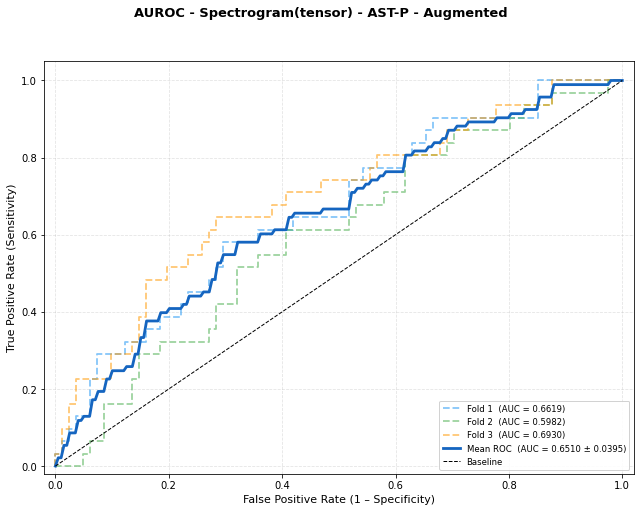


[✓] ROC plot saved → z:\AST-With-TB-Classify\exp\kfold_3runs_2dcnn\plots\roc_per_run.png

═══════════════════════════════════════════════════════
  AUC SUMMARY
───────────────────────────────────────────────────────
  Run 1  :  AUC = 0.6619
  Run 2  :  AUC = 0.5982
  Run 3  :  AUC = 0.6930
───────────────────────────────────────────────────────
  Mean   :  AUC = 0.6510
  ± Std  :       ± 0.0395
═══════════════════════════════════════════════════════


In [14]:
# ============================================================
# test_tb_AST-P_3Runs_2DCNNSplit.ipynb
# Plot ROC / AUC Curve per Run + Mean ± SD
# ============================================================
%matplotlib inline
import os
import json
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ------------------------------------------------------------------ #
# CONFIG — adjust to match your notebook paths
# ------------------------------------------------------------------ #
BASE_DIR  = r"z:\AST-With-TB-Classify"
EXP_ROOT  = os.path.join(BASE_DIR, "exp", "kfold_3runs_2dcnn")
FOLD_ROOT = os.path.join(BASE_DIR, "json_folds_3runs")
N_RUNS    = 3

# ------------------------------------------------------------------ #
# LOAD per-run predictions
# Each run_X/test_metrics.json does NOT store y_true / prob_ptb,
# so we load the raw lists from all_run_metrics saved as extended json.
# Fallback: re-load from per-run extended json if available,
#           otherwise raise clear error.
# ------------------------------------------------------------------ #

def load_run_predictions(run_num: int):
    """
    Try to load y_true and prob_ptb from
    exp/kfold_3runs_2dcnn/run_X/test_predictions.json
    (extended file that includes raw arrays).
    Falls back to test_metrics.json if arrays exist there.
    """
    run_exp_dir = os.path.join(EXP_ROOT, f"run_{run_num}")

    # --- Option A: dedicated predictions file (recommended) ----------
    pred_path = os.path.join(run_exp_dir, "test_predictions.json")
    if os.path.exists(pred_path):
        with open(pred_path) as f:
            d = json.load(f)
        return (np.array(d["y_true"]),
                np.array(d["prob_ptb"]),
                d.get("threshold", 0.5),
                d.get("auroc", None))

    # --- Option B: test_metrics.json (may not have raw arrays) -------
    metrics_path = os.path.join(run_exp_dir, "test_metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path) as f:
            d = json.load(f)
        if "y_true" in d and "prob_ptb" in d:
            return (np.array(d["y_true"]),
                    np.array(d["prob_ptb"]),
                    d.get("threshold", 0.5),
                    d.get("auroc", None))

    raise FileNotFoundError(
        f"[Run {run_num}] Cannot find prediction arrays.\n"
        f"  Expected: {pred_path}\n"
        f"  Or arrays in: {metrics_path}\n"
        f"  → Re-run Step 3 of the pipeline and save y_true/prob_ptb."
    )


# ------------------------------------------------------------------ #
# If `all_run_metrics` is already in memory (run from same kernel),
# use it directly — otherwise load from disk.
# ------------------------------------------------------------------ #
try:
    assert "all_run_metrics" in dir() or "all_run_metrics" in globals()
    _ = all_run_metrics[0]["y_true"]          # check raw arrays exist
    print("[✓] Using all_run_metrics from memory.")
    run_data = [
        (np.array(m["y_true"]),
         np.array(m["prob_ptb"]),
         m["threshold"],
         m["auroc"])
        for m in all_run_metrics
    ]
except Exception:
    print("[i] Loading predictions from disk …")
    run_data = [load_run_predictions(r) for r in range(1, N_RUNS + 1)]

# ------------------------------------------------------------------ #
# COMPUTE ROC per Run
# ------------------------------------------------------------------ #
mean_fpr   = np.linspace(0, 1, 200)
tpr_interp = []
run_fprs, run_tprs, run_aucs, run_thresholds = [], [], [], []

for idx, (y_true, prob_ptb, opt_thresh, stored_auroc) in enumerate(run_data):
    fpr, tpr, thresholds_roc = roc_curve(y_true, prob_ptb, pos_label=1)
    auroc_val = auc(fpr, tpr)

    tpr_i = np.interp(mean_fpr, fpr, tpr)
    tpr_i[0] = 0.0
    tpr_interp.append(tpr_i)

    youden_j  = tpr - fpr
    best_idx  = np.argmax(youden_j)
    thresh_fpr = fpr[best_idx]
    thresh_tpr = tpr[best_idx]

    run_fprs.append(fpr)
    run_tprs.append(tpr)
    run_aucs.append(auroc_val)
    run_thresholds.append((thresh_fpr, thresh_tpr, opt_thresh))

    print(f"  Run {idx+1}: AUROC = {auroc_val:.4f}  |  "
          f"Threshold (Youden) = {opt_thresh:.4f}  "
          f"→ FPR={thresh_fpr:.3f}, TPR={thresh_tpr:.3f}")

tpr_interp = np.array(tpr_interp)
mean_tpr   = tpr_interp.mean(axis=0)
mean_tpr[-1] = 1.0
std_tpr    = tpr_interp.std(axis=0)
mean_auc   = np.mean(run_aucs)
std_auc    = np.std(run_aucs)

# ------------------------------------------------------------------ #
# PLOT — Single Combined Graph
# ------------------------------------------------------------------ #
RUN_COLORS = ["#2196F3", "#4CAF50", "#FF9800"]   # blue, green, orange

fig, ax = plt.subplots(figsize=(9, 7))
fig.suptitle(
    "AUROC - Spectrogram(tensor) - AST-P - Augmented\n",
    fontsize=13, fontweight="bold", y=1.01
)

# ── Individual ROC curves (faded) + Youden markers ─────────────── #
for i, (fpr_i, tpr_i, auroc_i) in enumerate(zip(run_fprs, run_tprs, run_aucs)):
    ax.plot(fpr_i, tpr_i,
            color=RUN_COLORS[i],
            linewidth=1.8,
            alpha=0.55,
            linestyle="--",
            label=f"Fold {i+1}  (AUC = {auroc_i:.4f})")



# ── Mean ROC curve ─────────────────────────────────────────────── #
ax.plot(mean_fpr, mean_tpr,
        color="#1565C0",
        linewidth=2.8,
        label=f"Mean ROC  (AUC = {mean_auc:.4f} ± {std_auc:.4f})")

# ── Random baseline ────────────────────────────────────────────── #
ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Baseline")

# ── Axes formatting ────────────────────────────────────────────── #
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.05])
ax.set_xlabel("False Positive Rate (1 – Specificity)", fontsize=11)
ax.set_ylabel("True Positive Rate (Sensitivity)", fontsize=11)
ax.legend(loc="lower right", fontsize=8.5, framealpha=0.88)
ax.grid(True, linestyle="--", alpha=0.35)

plt.tight_layout()

# ------------------------------------------------------------------ #
# SAVE
# ------------------------------------------------------------------ #
plot_dir  = os.path.join(EXP_ROOT, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, "roc_per_run.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()

print(f"\n[✓] ROC plot saved → {plot_path}")
print(f"\n{'═'*55}")
print(f"  AUC SUMMARY")
print(f"{'─'*55}")
for i, a in enumerate(run_aucs):
    print(f"  Run {i+1}  :  AUC = {a:.4f}")
print(f"{'─'*55}")
print(f"  Mean   :  AUC = {mean_auc:.4f}")
print(f"  ± Std  :       ± {std_auc:.4f}")
print(f"{'═'*55}")